In [1]:
%pylab inline
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import scipy.stats
import scipy.optimize as opt
# %load_ext jupyternotify
def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()


Populating the interactive namespace from numpy and matplotlib


In [2]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f,p
# We have functions to convert proportion correct to z scores and vice versa
def ztop(z):
    p=0.5 * (1.0+scipy.special.erf(z/np.sqrt(2) ) )
    return p

def ptoz(p):
    if p==1:
        p=0.9999999
    elif p==0:
        p=0.0000001
    z=np.sqrt(2) * scipy.special.erfinv( 2*p-1.0)
    return z

def ptozM(p,M=10):
    if p==1:
        p=0.999999
    elif p==0:
        p=0.0001
    # from JEK Smith 1982. Checked to match tables of Hacker/Ratcliff
    K_M=0.86-0.085 * np.log(M-1)
    d=K_M*np.log( (M-1)*p/(1-p) )
    return d

# Function for getting bootstrapped zscores
def bootstrap_corr_to_z(df):
    num_boot=1000
    z_scores=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        zVal=ptozM(resampled_df.mean())
        z_scores.append(zVal)
    return z_scores

# Function for getting bootstrapped prop values from 0/1 correct/incorrect response list
def bootstrap_corr_to_propCor(df):
    num_boot=1000
    propCor=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        propCor.append(resampled_df.mean())
    return propCor

## Perumutation Test
def perm_test(c,t,num_perm,method='mean',z_score=True,*args):
    k=[]
    # Look if there are additional groups passed in
    if len(args)>1:
        t1=args[0]
        t2=agrs[1]
                
    if method=='mean':
        if z_score==True:
            diff=(ptozM(np.mean(c))-ptozM(np.mean(t)))
        else:
            diff=((np.mean(c))-(np.mean(t)))
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            if z_score==True:
                k.append((ptozM(np.mean(z[:int(len(c))])) - ptozM(np.mean(z[int(len(c)):]))))  
            else:
                k.append(((np.mean(z[:int(len(c))])) - (np.mean(z[int(len(c)):]))))  
        
    elif method=='ttest':
        # Compare between two sets of measures/data
        diff=stats.ttest_ind(c,t).statistic
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            tval=stats.ttest_ind(z[:int(len(c))],z[int(len(c)):])
            k.append(tval.statistic)
        
    elif method=='ftest':
        for arg in args:
            t2=arg
        if 't2' in locals():
            # Compare between more than two sets of measures/data
            diff,p_val=stats.f_oneway(c,t,t2).statistic
            z=np.concatenate([c,t,t2])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[:int(len(c))]
                g2=z[int(len(c)):(int(len(c))+int(len(t)))]
                g3=z[(int(len(c))+int(len(t))):]
                fval=stats.f_oneway(g1,g2,g3).statistic
                k.append(fval)
        else:
            # Compare between  two sets of measures/data
            diff,p_val=f_test(c,t)
            z=np.concatenate([c,t])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[0:int(len(c))]
                g2=z[int(len(c))::]
                fval,p_val=f_test(g1,g2)
                k.append(fval)
        
    elif method=='friedman':
        # compare between two sets of measures/data
        diff=stats.friedmanchisquare(c,t,t1,t2).statistic
        z=np.concatenate([c,t,t1,t2])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            len_df=len(c) # since lengths of groups are the same we use one of them
            g1=z[0:len_df]
            g2=z[len_df*1:len_df*2]
            g3=z[len_df*2:len_df*3]
            g4=z[len_df*3:len_df*4]
            friedman_test=stats.friedmanchisquare(g1,g2,g3,g4)
            k.append(friedman_test.statistic)
    if method=='mean':
        if diff>0: # when the original difference is positive
            p_value=len(np.where(k>=diff)[0])/num_perm
        elif diff<0: # when the original difference is negative
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)>0: # when the original difference is zero and distribution is positive
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)<0:# when the original difference is zero and distribution is negative
            p_value=len(np.where(k>=diff)[0])/num_perm
    else: # all other test statistic
        if diff<np.mean(k):
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff>np.mean(k):
            p_value=len(np.where(k>=diff)[0])/num_perm
            
    return {"diff":diff,"k":k,'p_val':p_value}

In [7]:
if sys.platform=='win32':
#     data_directory='Z:\TSLO_Experiment\VoluntaryMicrosaccade\Experiment2ObliqueMicrosaccadeWNeutral'
    data_directory='C:\TSLOBackup\CrowdingStream\crowding_microsaccade'
elif sys.platform=='linux':
    data_directory='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
filedir_list=[]
for root,dirs,file in os.walk(data_directory):
    if "Videos" in root and "Processed" not in root and "Pilot" not in root and "Training" not in root:
        filedir_list.append(root)

behav_compile=True
if behav_compile==True:
    # we get the path for the inidividual behavioral data files
    if sys.platform=='win32':
        behavdata_dir='C:\TSLOBackup\CrowdingStream\crowding_microsaccade'
    elif sys.platform=='linux':
        behavdata_dir='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
    behavdir_list=[]
    for root,dirs,file in os.walk(behavdata_dir):
        if "Behav"in root and "Pilot" not in root and "Training" not in root:
            behavdir_list.append(root)
        
# Saccade data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedMicroSacc=[]
microSaccData=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            #try:
            # First we load the mat file into jupyter
            mat=scipy.io.loadmat(os.path.join(foldername,filename))
            # we get the foldername from the filepath
#             folderdate=foldername.replace('/mnt/hd/ao/vids/','')
            # initially we create empty pandas dataframes
            tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                        ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
            # 1. form saccade dataset for the file
            if len((mat['params']['saccades'][0,0]))==0 or (mat['params']['saccades'][0,0].size)==0:
                tempSaccData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                    'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                    'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
            else:
                # we determine the size of the saccade array
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                        ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                saccArraySize=mat['params']['saccades'][0,0]['duration'].size # for now use one of the fields of the struct array
                durationList=[]
                onsetIdxList=[]
                offsetIdxList=[]
                onsetTimeList=[]
                offsetTimeList=[]
                xAmpList=[]
                yAmpList=[]
                VectorAmpList=[]
                DirectionList=[]
                peakVelList=[]
                maxVelList=[]
                for itemIdx in range(saccArraySize): #here we would want to unapack each item from the struct and append it to a list 
                    duration=(mat['params']['saccades'][0,0]['duration'][itemIdx].flatten().item().item())
                    onsetIdx=(mat['params']['saccades'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                    offsetIdx=(mat['params']['saccades'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                    onsetTime=((mat['params']['saccades'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                    offsetTime=(mat['params']['saccades'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                    xAmp=(mat['params']['saccades'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                    yAmp=(mat['params']['saccades'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                    VectorAmp=(mat['params']['saccades'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                    Direction=(mat['params']['saccades'][0,0]['direction'][itemIdx].flatten().item().item())
                    peakVel=(mat['params']['saccades'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                    maxVel=(mat['params']['saccades'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                    tempSaccData=tempSaccData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
            # We finally add file details to the data structure which can later be used to 
            # query into the dataframe
            if 'NoMicrosaccade' in filename:
                tempSaccData['microsaccade_cond']='NoMicrosaccade'
                trialCode='%s'%(filename[0:filename.find('_NoMicrosaccade')])
            else:
                tempSaccData['microsaccade_cond']='Microsaccade'
                trialCode='%s'%(filename[0:filename.find('_Video')])
            tempSaccData['filename']=filename
            
            tempSaccData['code']=trialCode
            tempSaccData['subj_id']=subj_id
#             tempSaccData['foldername']=folderdate
#             tempSaccData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])
            #The temporary data is then appended to the bigger data structure 
            microSaccData.append(tempSaccData)
            #except:
                #failedMicroSacc.append(os.path.join(foldername,filename))
# create_dataframe=True
microSaccData=pd.concat(microSaccData)
# we then remove the saccade data with NaNs
microSaccFiltered=microSaccData[microSaccData['Direction'].notnull()]

# Drift data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedDrifts=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            try:
                # First we load the mat file into jupyter
                mat=scipy.io.loadmat(os.path.join(foldername,filename))
                # we get the foldername from the filepath
    #             folderdate=foldername.replace('/mnt/hd/ao/rotVids/','')
                # initially we create empty pandas dataframes
                tempDriftData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
                # 1. form saccade dataset for the file
                if len((mat['params']['drifts'][0,0]))==0 or (mat['params']['drifts'][0,0].size)==0:
                    tempDriftData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                      'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                      'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
                else:
                    # we determine the size of the saccade array
                    tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                    driftArraySize=mat['params']['drifts'][0,0]['duration'].size # for now use one of the fields of the struct array
                    durationList=[]
                    onsetIdxList=[]
                    offsetIdxList=[]
                    onsetTimeList=[]
                    offsetTimeList=[]
                    xAmpList=[]
                    yAmpList=[]
                    VectorAmpList=[]
                    DirectionList=[]
                    peakVelList=[]
                    maxVelList=[]
                    for itemIdx in range(driftArraySize): #here we would want to unapack each item from the struct and append it to a list 
                        duration=(mat['params']['drifts'][0,0]['duration'][itemIdx].flatten().item().item())
                        onsetIdx=(mat['params']['drifts'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                        offsetIdx=(mat['params']['drifts'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                        onsetTime=((mat['params']['drifts'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                        offsetTime=(mat['params']['drifts'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                        xAmp=(mat['params']['drifts'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                        yAmp=(mat['params']['drifts'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                        VectorAmp=(mat['params']['drifts'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                        Direction=(mat['params']['drifts'][0,0]['direction'][itemIdx].flatten().item().item())
                        peakVel=(mat['params']['drifts'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                        maxVel=(mat['params']['drifts'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                        tempDriftData=tempDriftData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                  'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                  ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
                # We finally add file details to the data structure which can later be used to 
                # query into the dataframe
                if 'NoMicrosaccade' in filename:
                    tempDriftData['microsaccade_cond']='NoMicrosaccade'
                    trialCode='%s'%(filename[0:filename.find('_NoMicrosaccade')])
                else:
                    tempDriftData['microsaccade_cond']='Microsaccade'
                    trialCode='%s'%(filename[0:filename.find('_Video')])
                tempDriftData['filename']=filename
                tempSaccData['code']=trialCode
                tempDriftData['subj_id']=subj_id
                
    #             tempDriftData['foldername']=folderdate
    #             tempDriftData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])

                #The temporary data is then appended to the bigger data structure 
                driftData.append(tempDriftData)
            except:
                failedMicroSacc.append(os.path.join(foldername,filename))
#     create_dataframe=False
driftData=pd.concat(driftData)
# we then remove the saccade data with NaNs
driftDataFiltered=driftData[driftData['Direction'].notnull()]
  

if behav_compile==True:
    # Behav Data compilation
    behavdir_listles=[]
    behavData=[]
    questData=[]

    num_elements=len(behavdir_list)
    for foldername in behavdir_list:
        # we find subject ID
        subj_id=foldername[foldername.find('S0'):foldername.find('S0')+3]
        filelist=os.listdir(foldername)
        for filename in filelist:
            try:
                if 'Crowding' in filename and 'CrowdingQuest' not in filename and 'CrowdingThresh' not in filename:
                    # First we load the mat file into jupyter
                    tempBehav=pd.read_csv(os.path.join(foldername,filename))
                    tempBehav['filename']=filename
                    if "NoMicrosaccade"  in filename:
                        tempBehav['microsaccade_cond']='NoMicrosaccade'
                        trialCode='%s'%(filename[0:filename.find('_NoMicrosaccade')])
                    else:
                        tempBehav['microsaccade_cond']='Microsaccade'
                        trialCode='%s'%(filename[0:filename.find('_Crowding')])               
                    tempBehav['code']=trialCode
                    tempBehav['subj_id']=subj_id
                    #The temporary data is then appended to the bigger data structure 
                    behavData.append(tempBehav)
                elif "CrowdingThresh" in filename:
                    #We again load data into jupyter
                    tempData=pd.read_csv(os.path.join(foldername,filename))
                    tempData['subj_id']=subj_id
                    # ///rly we build the dataframe
                    questData.append(tempData)
            except:
                print(filename)
    if len(questData)!=0:
        questData=pd.concat(questData)
    behavData=pd.concat(behavData)
    
    
# Marker data compilation
failedFiles=[]
markerData=[]
markerFixNeeded=False
# while create_dataframe==True:
counter=0
num_elements=len(filedir_list)
for foldername in filedir_list:
#     update_progress(counter/num_elements)
    counter+=1
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'marker' in filename and 'markerData' not in filename:
            # First we load the mat file into jupyter
            tempData=pd.read_csv(os.path.join(foldername,filename),names=['frameIdx','stripIdx'])
            tempData['stimulusOnsetTime']=(tempData['frameIdx']*(1000/30)/1000)+(tempData['stripIdx']*(1000/16000)/1000)
            if markerFixNeeded==True:
                if len(tempData)!=2: # Cases where marker is missing we get values from behav data
                    if "NoMicrosaccade" in filename:
                        trialCode='%s'%(filename[0:filename.find('_Video')])
                    else:
                        trialCode='%s'%(filename[0:filename.find('_Microsaccade')])
                    # Get this from the marker file, since the first marker would correspond to the cue onset. 
                    # The second missing one would correspond to the target onset
                    if len(tempData)>0:
                        cueOnsetTime=tempData['stimulusOnsetTime'].iloc[0]
                        # We get the behavioral data from the trial
                        behavDataTrial=behavData.query("code==@trialCode")
                        if len(behavDataTrial)>0: # valid ones
                            # We get this from behavioral data
                            cueDuration=behavDataTrial['cueDuration'].iloc[0]
                            # Using the two we figure out when the target happened
                            targetOnsetTime=cueOnsetTime+cueDuration
                            # We create a df with dummy strip values & calculation target onset time
                            markerFix=pd.DataFrame([[np.nan,np.nan,targetOnsetTime]],columns=['frameIdx','stripIdx','stimulusOnsetTime'])
                            # We finally append this to existing marker data
                            tempData=tempData.append(markerFix)


            tempData['filename']=filename
            

            tempData['subj_id']=subj_id
            if 'NoMicrosaccade' in filename:
                tempData['microsaccade_cond']='NoMicrosaccade'
                tempData['code']='%s'%(filename[0:filename.find('_NoMicrosaccade')])
            else:
                tempData['microsaccade_cond']='Microsaccade'
                tempData['code']='%s'%(filename[0:filename.find('_Video')])
            #The temporary data is then appended to the bigger data structure 
            markerData.append(tempData)
            
markerData=pd.concat(markerData)

Percent: [#############################################################################################-------] 93.33333333333333%  

# Microsaccade Filtering
1. We aim to get only microsaccades that occur right after the very last/relevant stimulus from crowding sequence

In [8]:
# Compiles microsaccades that occur between the last & second last stimulus  
behavDataSaccade=behavData.query("microsaccade_cond=='Microsaccade'")
codeList=behavDataSaccade['code'].unique()
relSaccData=[]
for acode in codeList:
    try:
        lastStimTime=markerData.query("code==@acode")['stimulusOnsetTime'].iloc[-1]
        secondLastStimTime=markerData.query("code==@acode")['stimulusOnsetTime'].iloc[-2] 
        if lastStimTime=='NaN': # cases where the last stim message could not be captured in the retinal video
            continue
        else:
            tempSacc=microSaccFiltered.query("code==@acode & onsetTime>@secondLastStimTime & onsetTime<@lastStimTime")
            tempSacc['lastStimTime']=lastStimTime
            tempSacc['relOnsetTime']=tempSacc['onsetTime']-lastStimTime
            # get stimulus time relative to saccade onset
            if len(tempSacc)>0:
                saccOnsetTime=tempSacc['onsetTime'].iloc[0]
                relStimOnsetTime=lastStimTime-saccOnsetTime
            tempSacc['relStimTime']=relStimOnsetTime
            # we add only the first microsaccade to the saccade array
            relSaccData.append(tempSacc.head(1))
    except (IndexError,NameError) as e:
        pass
saccBetweenStim=pd.concat(relSaccData)


c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\krish\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


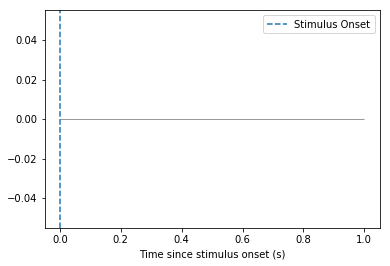

In [5]:
sns.distplot(saccBetweenStim['relOnsetTime'],kde=False,bins=25,hist_kws={"histtype": "step","color":"k"})
plt.axvline(x=0,ymin=0,ymax=1,label='Stimulus Onset',ls='--')
plt.xlabel('Time since stimulus onset (s)')
plt.legend()

In [16]:
# Compiles microsaccades that occurs following the last stimulus onset
behavDataSaccade=behavData.query("microsaccade_cond=='Microsaccade'")
codeList=behavDataSaccade['code'].unique()
relSaccData=[]
relStimTime=[]
relSacc=[]
for acode in codeList:
    try:
        lastStimTime=markerData.query("code==@acode")['stimulusOnsetTime'].iloc[-1]
        if lastStimTime=='NaN':
            continue
        else:
            # get only saccades that occur after final stimulus
            # We try to get only the first microsaccade that occurs after stimulus onset
            windowOfInterest=lastStimTime-0.300
            tempSacc=saccData.query("code==@acode & onsetTime>@windowOfInterest & onsetTime<@lastStimTime+0.5")
            if len(tempSacc)>0:
                sacc=tempSacc['onsetTime'].iloc[0]
                relSaccTime=sacc-lastStimTime
                relSacc.append(relSaccTime)
            tempSacc['lastStimTime']=lastStimTime
            tempSacc['relOnsetTime']=tempSacc['onsetTime']-lastStimTime
            # get stimulus time relative to saccade onset
            if len(tempSacc)>0:
                saccOnsetTime=tempSacc['onsetTime'].iloc[0]
                relStimOnsetTime=lastStimTime-saccOnsetTime
                relStimTime.append(relStimOnsetTime)
            tempSacc['relStimTime']=relStimOnsetTime
            # we add only the first microsaccade to the saccade array
            relSaccData.append(tempSacc.head(1))
    except (IndexError,NameError) as e:
        pass
relSaccData=pd.concat(relSaccData)


c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [17]:
os.chdir("D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingStream\Data")

saccData=pd.read_csv("saccData.csv")
behavData=pd.read_csv("behavData.csv")
markerData=pd.read_csv("markerData.csv")
relSaccData=pd.read_csv("relSaccData.csv")

Unnamed: 0  Duration  onsetIdx  offsetIdx  onsetTime  offsetTime  \
10             10  0.060438    2405.0     2434.0   5.010073    5.070511   
44             15  0.047929    3603.0     3626.0   7.506121    7.554051   
47              2  0.056289     729.0      756.0   1.517721    1.574010   
54              2  0.039604    1348.0     1367.0   2.807712    2.847316   
68             13  0.033342    3367.0     3383.0   7.014327    7.047669   
...           ...       ...       ...        ...        ...         ...   
16320           1  0.037526    1060.0     1078.0   2.207783    2.245309   
16326           4  0.037526    1043.0     1061.0   2.172342    2.209868   
16333           3  0.056279    1484.0     1511.0   3.091193    3.147473   
16344           9  0.035429    2663.0     2680.0   5.547760    5.583189   
16366           4  0.035435    1683.0     1700.0   3.505993    3.541428   

           xAmp      yAmp  VectorAmp   Direction    peakVel    meanVel  \
10     0.296866 -0.105229   0.314965  -19.517749  14.186725   8.922788   
44     0.183784  0.069932   0.196640   20.832428  10.778564   5.360756   
47    -0.847800  0.071042   0.850771  175.210032   9.828895   5.046619   
54    -0.126500  0.063689   0.141628  153.276084   5.843589   3.643906   
68     0.024998  0.063958   0.068670   68.651635   3.451460   2.102829   
...         ...       ...        ...         ...        ...        ...   
16320 -0.330120 -0.016988   0.330556 -177.054175  14.492517   8.647982   
16326 -0.463307 -0.129041   0.480942 -164.436339  21.472286  12.398566   
16333 -0.409331  0.016709   0.409672  177.662488  13.016908   7.207052   
16344 -0.589404 -0.045116   0.591128 -175.622845  24.870802  16.144345   
16366  0.192688 -0.064332   0.203144  -18.462386   9.266824   5.508499   

      microsaccade_cond                                           filename  \
10         Microsaccade  S01_S1_T00100_ecc_2_spacing_1.6_Video_04_28_20...   
44         Microsaccade  S01_S1_T00102_ecc_2_spacing_100_Video_04_28_20...   
47         Microsaccade  S01_S1_T00102_ecc_5_spacing_100_Video_04_28_20...   
54         Microsaccade  S01_S1_T00103_ecc_2_spacing_1.6_Video_04_28_20...   
68         Microsaccade  S01_S1_T00103_ecc_5_spacing_1.6_Video_04_28_20...   
...                 ...                                                ...   
16320      Microsaccade  S05_S2_T0097_ecc_2_spacing_1.6_Video_05_13_202...   
16326      Microsaccade  S05_S2_T0097_ecc_5_spacing_1.6_Video_05_13_202...   
16333      Microsaccade  S05_S2_T0098_ecc_2_spacing_100_Video_05_13_202...   
16344      Microsaccade  S05_S2_T0098_ecc_5_spacing_100_Video_05_13_202...   
16366      Microsaccade  S05_S2_T009_ecc_5_spacing_100_Video_05_13_2021...   

                                  code subj_id  lastStimTime  relOnsetTime  \
10     S01_S1_T00100_ecc_2_spacing_1.6     S01      5.190229     -0.180156   
44     S01_S1_T00102_ecc_2_spacing_100     S01      7.345896      0.160226   
47     S01_S1_T00102_ecc_5_spacing_100     S01      1.809313     -0.291592   
54     S01_S1_T00103_ecc_2_spacing_1.6     S01      3.087417     -0.279704   
68     S01_S1_T00103_ecc_5_spacing_1.6     S01      7.295792     -0.281465   
...                                ...     ...           ...           ...   
16320   S05_S2_T0097_ecc_2_spacing_1.6     S05      2.335396     -0.127613   
16326   S05_S2_T0097_ecc_5_spacing_1.6     S05      2.278104     -0.105762   
16333   S05_S2_T0098_ecc_2_spacing_100     S05      3.149083     -0.057890   
16344   S05_S2_T0098_ecc_5_spacing_100     S05      5.336146      0.211614   
16366    S05_S2_T009_ecc_5_spacing_100     S05      3.188354      0.317639   

       relStimTime  
10        0.180156  
44       -0.160226  
47        0.291592  
54        0.279704  
68        0.281465  
...            ...  
16320     0.127613  
16326     0.105762  
16333     0.057890  
16344    -0.211614  
16366    -0.317639  

[1752 rows x 19 columns]

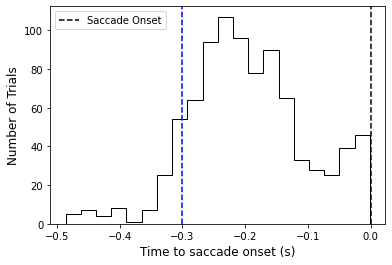

In [18]:
plt.hist(relSaccData.query("relStimTime<0")['relStimTime'],bins=20,histtype='step',color='k')
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color='k',label='Saccade Onset')
plt.axvline(x=-0.3,ymin=0,ymax=1,ls='--',color='b')
plt.ylabel("Number of Trials",size=12)
plt.xlabel('Time to saccade onset (s)',size=12)
plt.legend()
# plt.savefig('..\plots\RelativeStimulusOnsetTime.svg',format='svg',dpi=1200,bbox_inches='tight')

In [19]:
# We can also get the number of stimuli presented across trials
codeList=markerData['code'].unique()
numStim=[]
for acode in codeList:
    numberofstimuli=len(markerData.query("code==@acode"))
    numStim.append(numberofstimuli)

Text(0, 0.5, 'Number of trials')

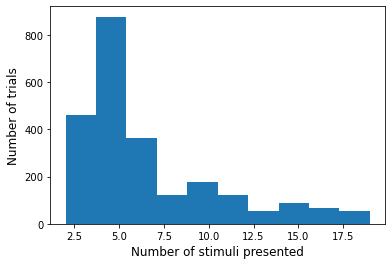

In [20]:
bins=plt.hist(np.array(numStim),bins=10)
plt.xlabel('Number of stimuli presented',size=12)
plt.ylabel('Number of trials',size=12)

# Binning protocol:
Here we perform the binning of behavioral performance as a function of time the stimulus came on relative to saccade onset. We used two different methods to perform the binning
1. Constant bin widths
2. Variable bin widths

In [22]:
# GROUP BASED ON CONGRUENCY
# First created merged saccade data frame
behavFiltered=behavDataSaccade.query("resp!='NaN'")
relSaccDataMerged=pd.merge(relSaccData,behavFiltered,left_on='code',right_on='code',copy=False)
# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that
# are below 0
relSaccDataMerged['DirectionPolar']=0
for i in range(len(relSaccDataMerged)):
    if relSaccDataMerged['Direction'].iloc[i]<0:
        relSaccDataMerged['DirectionPolar'].iloc[i]=relSaccDataMerged['Direction'].iloc[i]+360
    else:
        relSaccDataMerged['DirectionPolar'].iloc[i]=relSaccDataMerged['Direction'].iloc[i]
# here we segregate the microsaccade data based on whether they were leftward or rightward.
# Criterion is based on Baumeler et al. 2020
# Krish June 21': Modified this to include only saccades 45° away from horizontal meridian
rightupSacc=relSaccDataMerged.query("DirectionPolar<45 ")
rightdownSacc=relSaccDataMerged.query("(DirectionPolar>315)")
rightwardSacc=rightupSacc.append(rightdownSacc)
rightwardSacc['leftVright']='right'
leftwardSacc=relSaccDataMerged.query("(DirectionPolar>135) & (DirectionPolar<225)")
leftwardSacc['leftVright']='left'
leftVrightData=leftwardSacc.append(rightwardSacc)     
leftVrightData['congruent']= np.where((leftVrightData['stim_loc'] == leftVrightData['leftVright']),1 ,0)

c:\Users\krish\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Filter saccade data based on relative stimulus onset time


In [72]:
sacc300msOnsetDF=leftVrightData.query("relStimTime>-0.300")

# We set the value that would be used to distinguish between saccade & no saccade trials
# no microsaccade trials
behavDataNoMicrosaccadeWsaccades=list(behavData.query("microsaccade_cond=='NoMicrosaccade'")['code'])
NoMicroSaccadeFailedTrial=relSaccData.query("code==@behavDataNoMicrosaccadeWsaccades and relStimTime>-0.300")['code']
behavDataNoMicrosaccade=behavData[behavData.code.isin(behavDataNoMicrosaccadeWsaccades)]

## Microsaccade direction

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


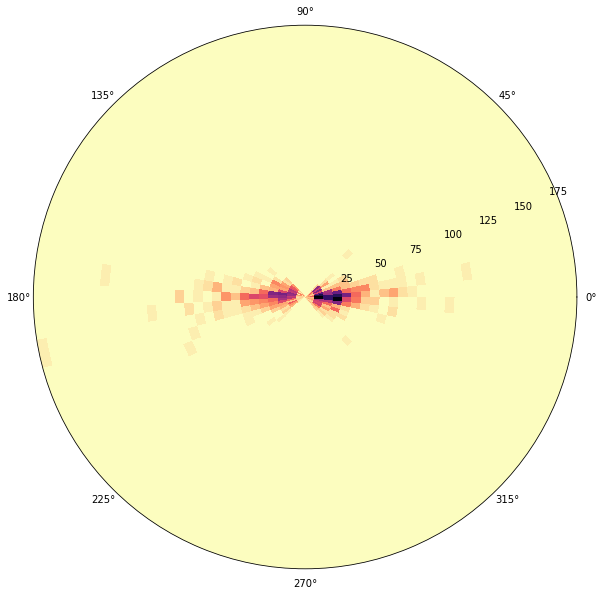

In [151]:
df=sacc300msOnsetDF
arr=np.radians(df['DirectionPolar'])
radius=df['VectorAmp']*60

# define binning
rbins = np.linspace(0,radius.max(), 30)
abins = np.linspace(0,2*np.pi, 60)
#calculate histogram
hist, _, _ = np.histogram2d(arr, radius, bins=(abins, rbins))
A, R = np.meshgrid(abins, rbins)

fig,ax=plt.subplots(1,1,subplot_kw={'projection':'polar'},figsize=(10,10))
pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")

plt.savefig("..\Plots\MicrosaccadeDirection.svg",dpi=1200,bbox_tight='inches')

## Stimulus onset frequency ditribution relative to saccade onset

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  


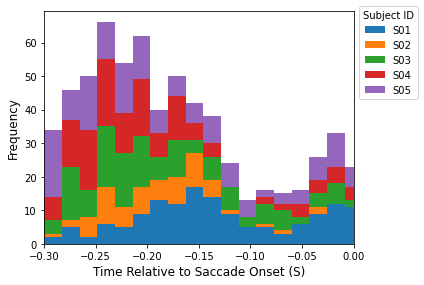

In [33]:
df=sacc300msOnsetDF
plt.hist([df.query("subj_id_x=='S01'")['relStimTime'],df.query("subj_id_x=='S02'")['relStimTime'],df.query("subj_id_x=='S03'")['relStimTime'],df.query("subj_id_x=='S04'")['relStimTime'],df.query("subj_id_x=='S05'")['relStimTime']],stacked=True,bins=35,label=['S01','S02','S03','S04','S05'])
plt.legend(title='Subject ID',bbox_to_anchor=(1,0.6))
plt.xlabel("Time Relative to Saccade Onset (S)",size=12)
plt.ylabel("Frequency",size=12)
plt.tight_layout()
plt.xlim(-0.3,0)
plt.savefig("..\Plots\stimuliOnsetRelativetoSaccade.svg",dpi=1200,bbox_tight='inches')

## Compare behavioral performance between trials with microsaccades and ones without

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

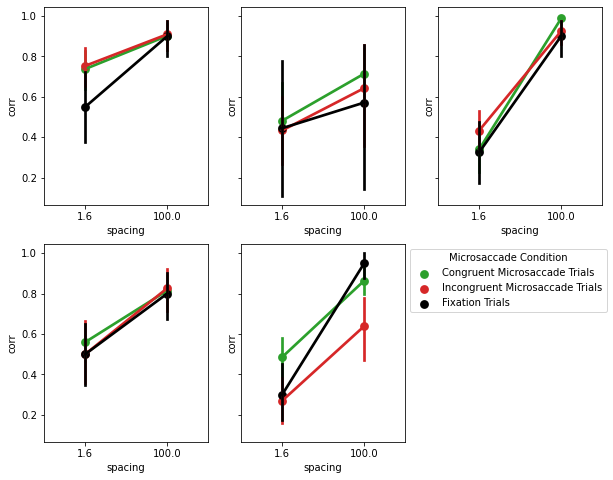

In [81]:
fig,axs=plt.subplots(2,3,figsize=(10,8),sharey=True)
subs=sacc300msOnsetDF.subj_id_x.unique()
subCounter=0
for row in axs:
    for col in row:
        if subCounter!=5:
            asub=subs[subCounter]
            df1=sacc300msOnsetDF.query("congruent==1 & subj_id_x==@asub")
            df2=sacc300msOnsetDF.query("congruent==0 & subj_id_x==@asub")
            df3=behavDataNoMicrosaccade.query("subj_id==@asub")
            df1['trialCond']='Congruent Microsaccade Trials'
            df2['trialCond']='Incongruent Microsaccade Trials'
            df3['trialCond']='Fixation Trials'
            sns.pointplot(data=df1,hue='trialCond',x='spacing',y='corr',palette=['C2'],ax=col)
            sns.pointplot(data=df2,hue='trialCond',x='spacing',y='corr',palette=['C3'],ax=col)
            sns.pointplot(data=df3,hue='trialCond',x='spacing',y='corr',palette=['k'],ax=col)
            if subCounter==4:
                col.legend(title='Microsaccade Condition',bbox_to_anchor=(1,1))
            else:
                col.get_legend().remove()
            subCounter+=1
        else:
            fig.delaxes(col)
        # col.xlabel("Flanker Spacing",size=12)
        # col.ylabel("Proportion Correct",size=12)

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

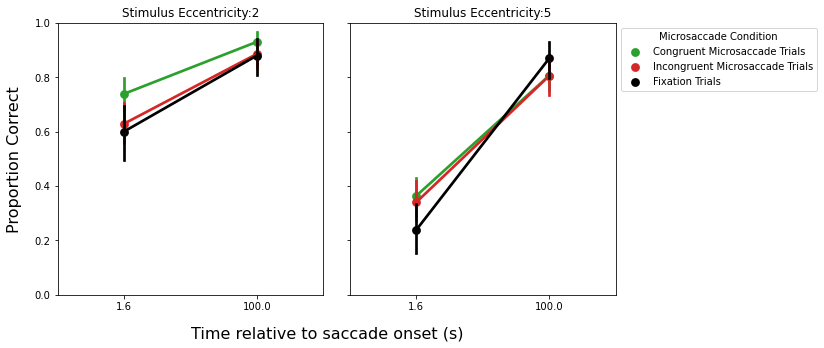

In [124]:
fig,axs=plt.subplots(1,2,sharey=True,figsize=(10,5))
ecc_list=[2,5]
eccCounter=0
for row in axs:
    anecc=ecc_list[eccCounter]
    df1=sacc300msOnsetDF.query("congruent==1 & ecc==@anecc")
    df2=sacc300msOnsetDF.query("congruent==0 & ecc==@anecc")
    df3=behavDataNoMicrosaccade.query("ecc==@anecc")
    df1['trialCond']='Congruent Microsaccade Trials'
    df2['trialCond']='Incongruent Microsaccade Trials'
    df3['trialCond']='Fixation Trials'
    sns.pointplot(data=df1,hue='trialCond',x='spacing',y='corr',palette=['C2'],ax=row)
    sns.pointplot(data=df2,hue='trialCond',x='spacing',y='corr',palette=['C3'],ax=row)
    sns.pointplot(data=df3,hue='trialCond',x='spacing',y='corr',palette=['k'],ax=row)
    row.set_title("Stimulus Eccentricity:%d"%(anecc))
    row.set_xlabel('')
    row.set_ylabel('')
    row.set_ylim(0,1)
    if eccCounter==1:
        row.legend(title="Microsaccade Condition",bbox_to_anchor=(1,1))
    else:
        row.get_legend().remove()
    eccCounter+=1
fig.text(0.055,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.005,'Time relative to saccade onset (s)',size=16,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)

## Z Score VS Spacing plots

In [125]:
###### subs=behavData.subj_id.unique()
spacing_list=sacc300msOnsetDF.spacing.unique()
subs=sacc300msOnsetDF.subj_id_x.unique()
eccs=sacc300msOnsetDF.ecc.unique()
zScore_sacc=[]
zScore_noSacc=[]
total_iter=len(spacing_list) * len(eccs)
counter=1
for aspacing in spacing_list:
    for anecc in eccs:
        print("%d/%d"%(counter,total_iter),end='\r')
        #No Saccade Trials
        data_nosacc=behavDataNoMicrosaccade.query("spacing==@aspacing & ecc==@anecc")['corr']
        propVals=bootstrap_corr_to_propCor(data_nosacc)
        zScores=bootstrap_corr_to_z(data_nosacc)
        tempDF_nosacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_nosacc['spacing']=aspacing
        tempDF_nosacc['ecc']=anecc
        zScore_noSacc.append(tempDF_nosacc)
        #Saccade Trials: Congruent
        data_sacc=sacc300msOnsetDF.query("spacing==@aspacing & congruent==1 & ecc==@anecc")['corr']
        propVals=bootstrap_corr_to_propCor(data_sacc)
        zScores=bootstrap_corr_to_z(data_sacc)
        tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_sacc['spacing']=aspacing
        tempDF_sacc['congruency']=1
        tempDF_sacc['ecc']=anecc
        zScore_sacc.append(tempDF_sacc)
        #Saccade Trials: Incongruent
        data_sacc=sacc300msOnsetDF.query("spacing==@aspacing & congruent==0 & ecc==@anecc")['corr']
        propVals=bootstrap_corr_to_propCor(data_sacc)
        zScores=bootstrap_corr_to_z(data_sacc)
        tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_sacc['spacing']=aspacing
        tempDF_sacc['congruency']=0
        tempDF_sacc['ecc']=anecc
        zScore_sacc.append(tempDF_sacc)
        counter+=1
zScore_sacc=pd.concat(zScore_sacc)
zScore_noSacc=pd.concat(zScore_noSacc)

In [126]:
zScore_sacc.to_csv("zScore_sacc.csv")
zScore_noSacc.to_csv("ZScore_nosacc.csv")

2000
2000


c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

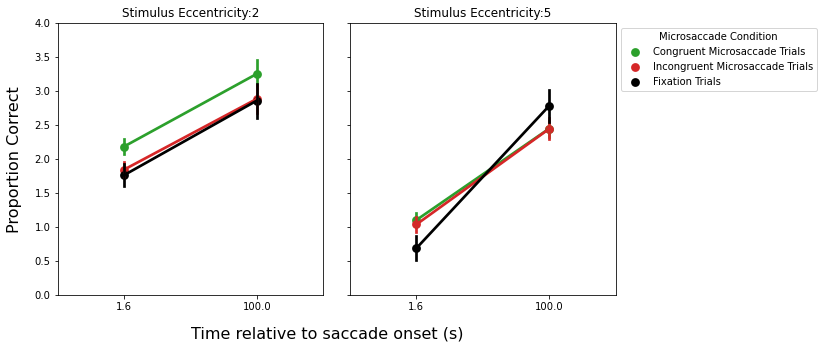

In [136]:
fig,axs=plt.subplots(1,2,sharey=True,figsize=(10,5))
ecc_list=[2,5]
eccCounter=0
for row in axs:
    anecc=ecc_list[eccCounter]
    df1=zScore_sacc.query("congruency==1 & ecc==@anecc")
    df2=zScore_sacc.query("congruency==0 & ecc==@anecc")
    df3=zScore_noSacc.query("ecc==@anecc")
    print(len(df3))
    df1['trialCond']='Congruent Microsaccade Trials'
    df2['trialCond']='Incongruent Microsaccade Trials'
    df3['trialCond']='Fixation Trials'
    sns.pointplot(data=df1,hue='trialCond',x='spacing',y='zScores',palette=['C2'],ci='sd',ax=row)
    sns.pointplot(data=df2,hue='trialCond',x='spacing',y='zScores',palette=['C3'],ci='sd',ax=row)
    sns.pointplot(data=df3,hue='trialCond',x='spacing',y='zScores',palette=['k'],ci='sd',ax=row)
    row.set_title("Stimulus Eccentricity:%d"%(anecc))
    row.set_xlabel('')
    row.set_ylabel('')
    row.set_ylim(0,4)
    if eccCounter==1:
        row.legend(title="Microsaccade Condition",bbox_to_anchor=(1,1))
    else:
        row.get_legend().remove()
    eccCounter+=1
fig.text(0.055,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.005,'Time relative to saccade onset (s)',size=16,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)

### 1. Constant Bin widths

In [138]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.050 #seconds
binSize=0.100

startPt=-0.300
endPt=0.050
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=sacc300msOnsetDF.subj_id_x.unique()
eccs=sacc300msOnsetDF.ecc.unique()
numelements=len(subs)*len(bins)*len(eccs)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc_combined=[]
BinDataPerf_nosacc_combined=[]
for asub in subs:
    for anecc in eccs:
        for abin in bins:
            start=abin-binWidth
            end=abin+binWidth
            # Trials with microsaccades present
            print('%d/%d'%(counter,numelements),end='\r')
            # Congruent Msacc
            perfDF=sacc300msOnsetDF.query("@start<relStimTime<@end & subj_id_x==@asub & congruent==1 & ecc==@anecc").drop_duplicates(subset=['code'])
            perfDF['binPt']=abin
            perfDF['congruent']=1
            perfDF['ecc']=anecc
            BinDataPerf_sacc_combined.append(perfDF)
            #incongruent Msacc
            perfDF=sacc300msOnsetDF.query("@start<relStimTime<@end & subj_id_x==@asub & congruent==0 & ecc==@anecc").drop_duplicates(subset=['code'])
            perfDF['binPt']=abin
            perfDF['congruent']=0
            perfDF['ecc']=anecc
            BinDataPerf_sacc_combined.append(perfDF)
            counter+=1
        #Trials W/o microsaccades 
        datanoSacc=behavDataNoMicrosaccade.query("subj_id==@asub & ecc==@anecc")
        BinDataPerf_nosacc_combined.append(datanoSacc)
                    
BinDataPerf_sacc_combined=pd.concat(BinDataPerf_sacc_combined)
BinDataPerf_nosacc_combined=pd.concat(BinDataPerf_nosacc_combined)

Text(0.5, 0.025, 'Time relative to saccade onset (s)')

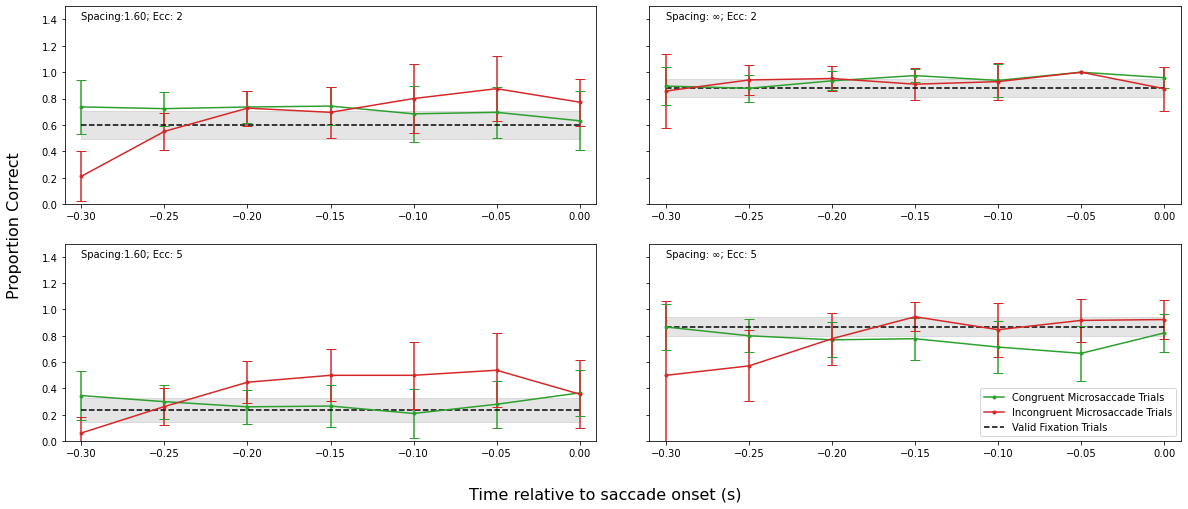

In [144]:
fig,axs=plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(20,8))
spacings= [  1.6,100.,1.6,100]
subs=BinDataPerf_sacc_combined.subj_id_x.unique()
eccs=[2,2,5,5]
colCounter=0
rowCounter=0
for row in axs:    
    for col in row:
        aspacing=spacings[colCounter]
        anecc=eccs[rowCounter]
        #Microsaccade Condition:congruent
        subs_list=['S01','S02','S03','S04','S05']
        query_string="spacing==@aspacing & subj_id_x==@subs_list & congruent==1 & ecc==@anecc"
        df2_mean=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df2_std=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].std().reset_index()
        df2_count=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].count().reset_index()
        x2=df2_std['binPt']
        ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
        col.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent Microsaccade Trials',color='C2',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

        #Microsaccade Condition:congruent
        subs_list=['S01','S02','S03','S04','S05']
        query_string="spacing==@aspacing & subj_id_x==@subs_list & congruent==0 & ecc==@anecc"
        df2_mean=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df2_std=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].std().reset_index()
        df2_count=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].count().reset_index()
        x2=df2_std['binPt']
        ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
        col.plot(df2_mean['binPt'],df2_mean['corr'],label='Incongruent Microsaccade Trials',color='C3',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C3',ls = 'none',capsize = 5)

        #No saccade condition
        query_string="spacing==@aspacing & subj_id==@subs_list & ecc==@anecc"
        df3_mean=BinDataPerf_nosacc_combined.query(query_string)['corr'].mean()
        # Compute CI
        df3_std=BinDataPerf_nosacc_combined.query(query_string)['corr'].std()
        df3_count=BinDataPerf_nosacc_combined.query(query_string)['corr'].count()
        ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
        xvalues=np.linspace(startPt,0,5)
        col.hlines(xmin=startPt,xmax=0,y=df3_mean,label='Valid Fixation Trials',color='k',linestyle='--')
        col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
        col.set_xlim(startPt-0.010,0.010)
        col.set_ylim(0,1.5)
        if colCounter==3:
            col.legend(loc='lower right')
        if aspacing!=100:
            col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.1,"Spacing:%.2f; Ecc: %d"%(aspacing,anecc))
        else:
            col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.1,"Spacing: ∞; Ecc: %d"%(anecc))
        colCounter+=1
        rowCounter+=1
fig.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.085,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

## Temporal profile of Zscores

In [154]:
BinDataPerf_sacc_combined

Unnamed: 0_x  Duration  onsetIdx  offsetIdx  onsetTime  offsetTime  \
197              3  0.033347    2013.0     2029.0   4.193414    4.226761   
136              7  0.037516    1879.0     1897.0   3.914131    3.951647   
320              3  0.054204    1237.0     1263.0   2.576789    2.630994   
68               5  0.050012    3826.0     3850.0   7.970595    8.020607   
74               3  0.056279    1386.0     1413.0   2.886920    2.943200   
...            ...       ...       ...        ...        ...         ...   
1550             5  0.039611     869.0      888.0   1.809590    1.849201   
1609             2  0.037526     873.0      891.0   1.817929    1.855455   
1668             4  0.043773    1303.0     1324.0   2.713913    2.757686   
1700             4  0.097968    1323.0     1370.0   2.755602    2.853570   
1737             4  0.037520    1519.0     1537.0   3.164148    3.201668   

          xAmp      yAmp  VectorAmp   Direction  ...  stim_dur  corr  \
197   0.267717 -0.016187   0.268206   -3.459974  ...     0.048   1.0   
136  -0.111460 -0.057339   0.125344 -152.777115  ...     0.048   0.0   
320  -0.058629  0.025927   0.064106  156.144118  ...     0.048   1.0   
68    0.160422  0.005314   0.160510    1.897365  ...     0.048   1.0   
74    0.175555  0.075595   0.191139   23.296964  ...     0.048   0.0   
...        ...       ...        ...         ...  ...       ...   ...   
1550 -0.409672 -0.042561   0.411877 -174.068841  ...     0.048   1.0   
1609 -0.227937 -0.025914   0.229405 -173.513879  ...     0.048   0.0   
1668 -0.127938 -0.020864   0.129628 -170.737862  ...     0.048   1.0   
1700 -0.318767  0.021064   0.319462  176.219411  ...     0.048   1.0   
1737 -0.164028 -0.025031   0.165927 -171.323554  ...     0.048   1.0   

        stimTime                                         filename_y  \
197    41.899963  S01_S2_T00102_ecc_5_spacing_100_Crowding_04_28...   
136   332.759402  S01_S1_T0069_ecc_5_spacing_1.6_Crowding_04_26_...   
320   131.167040  S01_S2_T0064_ecc_5_spacing_100_Crowding_04_27_...   
68     77.003669  S01_S1_T0029_ecc_5_spacing_100_Crowding_04_26_...   
74     97.429494  S01_S1_T0031_ecc_5_spacing_1.6_Crowding_04_26_...   
...          ...                                                ...   
1550   68.157170  S05_S1_T0091_ecc_2_spacing_1.6_Crowding_05_12_...   
1609   45.880310  S05_S2_T0016_ecc_2_spacing_100_Crowding_05_13_...   
1668   23.956666  S05_S2_T0051_ecc_2_spacing_1.6_Crowding_05_13_...   
1700   81.233862  S05_S2_T0070_ecc_2_spacing_100_Crowding_05_13_...   
1737   52.246016  S05_S2_T0091_ecc_2_spacing_100_Crowding_05_13_...   

     microsaccade_cond_y subj_id_y  DirectionPolar  leftVright  congruent  \
197         Microsaccade       S01      356.540026       right          1   
136         Microsaccade       S01      207.222885        left          0   
320         Microsaccade       S01      156.144118        left          0   
68          Microsaccade       S01        1.897365       right          1   
74          Microsaccade       S01       23.296964       right          1   
...                  ...       ...             ...         ...        ...   
1550        Microsaccade       S05      185.931159        left          0   
1609        Microsaccade       S05      186.486121        left          0   
1668        Microsaccade       S05      189.262138        left          0   
1700        Microsaccade       S05      176.219411        left          0   
1737        Microsaccade       S05      188.676446        left          0   

             binPt  
197  -3.000000e-01  
136  -3.000000e-01  
320  -3.000000e-01  
68   -2.500000e-01  
74   -2.500000e-01  
...            ...  
1550 -5.551115e-17  
1609 -5.551115e-17  
1668 -5.551115e-17  
1700 -5.551115e-17  
1737 -5.551115e-17  

[1360 rows x 41 columns]

In [ ]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.050 #seconds
binSize=0.100

startPt=-0.300
endPt=0.050
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=zScore_sacc.subj_id_x.unique()
eccs=sacc300msOnsetDF.ecc.unique()
numelements=len(subs)*len(bins)*len(eccs)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc_combined=[]
BinDataPerf_nosacc_combined=[]
for anecc in eccs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        # Congruent Msacc
        perfDF=sacc300msOnsetDF.query("@start<relStimTime<@end congruent==1 & ecc==@anecc").drop_duplicates(subset=['code'])
        perfDF['binPt']=abin
        perfDF['congruent']=1
        perfDF['ecc']=anecc
        BinDataPerf_sacc_combined.append(perfDF)
        #incongruent Msacc
        perfDF=sacc300msOnsetDF.query("@start<relStimTime<@end & subj_id_x==@asub & congruent==0 & ecc==@anecc").drop_duplicates(subset=['code'])
        perfDF['binPt']=abin
        perfDF['congruent']=0
        perfDF['ecc']=anecc
        BinDataPerf_sacc_combined.append(perfDF)
        counter+=1
        #Trials W/o microsaccades 
        datanoSacc=behavDataNoMicrosaccade.query("subj_id==@asub & ecc==@anecc")
        BinDataPerf_nosacc_combined.append(datanoSacc)
                    
BinDataPerf_sacc_combined=pd.concat(BinDataPerf_sacc_combined)
BinDataPerf_nosacc_combined=pd.concat(BinDataPerf_nosacc_combined)

In [ ]:
fig,axs=plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(20,8))
spacings= [  1.6,100.,1.6,100]
subs=BinDataPerf_sacc_combined.subj_id_x.unique()
eccs=[2,2,5,5]
colCounter=0
rowCounter=0
for row in axs:    
    for col in row:
        aspacing=spacings[colCounter]
        anecc=eccs[rowCounter]
        #Microsaccade Condition:congruent
        subs_list=['S01','S02','S03','S04','S05']
        query_string="spacing==@aspacing & subj_id_x==@subs_list & congruent==1 & ecc==@anecc"
        df2_mean=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df2_std=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].std().reset_index()
        df2_count=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].count().reset_index()
        x2=df2_std['binPt']
        ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
        col.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent Microsaccade Trials',color='C2',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

        #Microsaccade Condition:congruent
        subs_list=['S01','S02','S03','S04','S05']
        query_string="spacing==@aspacing & subj_id_x==@subs_list & congruent==0 & ecc==@anecc"
        df2_mean=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df2_std=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].std().reset_index()
        df2_count=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].count().reset_index()
        x2=df2_std['binPt']
        ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
        col.plot(df2_mean['binPt'],df2_mean['corr'],label='Incongruent Microsaccade Trials',color='C3',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C3',ls = 'none',capsize = 5)

        #No saccade condition
        query_string="spacing==@aspacing & subj_id==@subs_list & ecc==@anecc"
        df3_mean=BinDataPerf_nosacc_combined.query(query_string)['corr'].mean()
        # Compute CI
        df3_std=BinDataPerf_nosacc_combined.query(query_string)['corr'].std()
        df3_count=BinDataPerf_nosacc_combined.query(query_string)['corr'].count()
        ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
        xvalues=np.linspace(startPt,0,5)
        col.hlines(xmin=startPt,xmax=0,y=df3_mean,label='Valid Fixation Trials',color='k',linestyle='--')
        col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
        col.set_xlim(startPt-0.010,0.010)
        col.set_ylim(0,1.5)
        if colCounter==3:
            col.legend(loc='lower right')
        if aspacing!=100:
            col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.1,"Spacing:%.2f; Ecc: %d"%(aspacing,anecc))
        else:
            col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.1,"Spacing: ∞; Ecc: %d"%(anecc))
        colCounter+=1
        rowCounter+=1
fig.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.085,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

## Temporal profile of crowding strength

In [145]:
# We calculate crowding strength/ difference in z score between unflanked and flanked
crowdedSacc_df=BinDataPerf_sacc_combined.query("spacing==1.6")
uncrowdedSacc_df=BinDataPerf_sacc_combined.query("spacing==100")
crowdedSacc_df.reset_index(inplace=True)
uncrowdedSacc_df.reset_index(inplace=True)
crowding_strengthSacc_df=crowdedSacc_df[['ecc','binPt']]
crowding_strengthSacc_df['sacc_cond']='microsaccade'
crowding_strengthSacc_df['crowding_strength']=uncrowdedSacc_df['zScores'] - crowdedSacc_df['zScores']
# Do the same for no saccde condition
crowdedFix_df=BinDataPerf_nosacc_combined.query("spacing==1.6")
uncrowdedFix_df=BinDataPerf_nosacc_combined.query("spacing==100")
crowdedFix_df.reset_index(inplace=True)
uncrowdedFix_df.reset_index(inplace=True)
crowding_strengthFix_df=crowdedFix_df[['ecc']]
crowding_strengthFix_df['sacc_cond']='nomicrosaccade'
crowding_strengthFix_df['crowding_strength']=uncrowdedFix_df['zScores'] - crowdedFix_df['zScores']
crowding_strengthFix_df['binPt']=-0.200


c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


KeyError: 'zScores'

In [10]:
# 1. Stat Test between fixation condition and saccade condition
# We run permutation ftest between fixation and each of the saccade bin points individually
# We run permutation test for each time point/bin step 
bins=binSacc_grouped.binPt.unique()
bin_list=[]
ecc_list=[]
crowded_list=[]
p_vals_prop=[]
idx=1
tot_count=(len(bins)*len(binSacc_grouped.ecc.unique())*len(binSacc_grouped.spacing.unique()))
# loop through each bin
for anecc in binSacc_grouped.ecc.unique():
    for crowding_cond in binSacc_grouped.spacing.unique():
        group1_prop=behavDataNoSaccade.query("spacing==@crowding_cond and ecc==@anecc and subj_id!='S02'")['corr']
        for abin in bins:
            print('%d/%d'%(idx,tot_count),end='\r')
            idx+=1
            # Temporary fix for crowded spacing, which otherwise retruns empty on query
            group2_prop=binSacc_grouped.query("binPt==@abin and spacing==@crowding_cond and ecc==@anecc & corr<2 and subj_id_x!='S02'")['corr'] 
            res_prop=perm_test(group1_prop,group2_prop,10000,'mean',z_score=False)
            # append values to list
            bin_list.append(abin)
            p_vals_prop.append(res_prop['p_val'])
            ecc_list.append(anecc)
            crowded_list.append(crowding_cond)
# z_score=ptoz(np.array(p_vals_perf))
np_df=np.column_stack((bin_list,p_vals_prop,ecc_list,crowded_list))
p_val_fix_constant_df=pd.DataFrame(np_df,columns=['bins','p_val','ecc','spacing'])

In [11]:
# 1. Stat Test between fixation condition and saccade condition
# We run permutation ftest between fixation and each of the saccade bin points individually
# We run permutation test for each time point/bin step 
bins=binSacc_grouped.binPt.unique()
bin_list=[]
ecc_list=[]
crowded_list=[]
p_vals_prop=[]
idx=1
tot_count=(len(bins)*len(binSacc_grouped.ecc.unique())*len(binSacc_grouped.spacing.unique()))
# loop through each bin
for anecc in binSacc_grouped.ecc.unique():
    for crowding_cond in binSacc_grouped.spacing.unique():
        group1_prop=behavDataNoSaccade.query("spacing==@crowding_cond and ecc==@anecc and subj_id!='S02'")['corr']
        for abin in bins:
            print('%d/%d'%(idx,tot_count),end='\r')
            idx+=1
            # Temporary fix for crowded spacing, which otherwise retruns empty on query
            group2_prop=binSacc_grouped.query("binPt==@abin and spacing==@crowding_cond and ecc==@anecc & corr<2 and subj_id_x!='S02'")['corr'] 
            res_prop=perm_test(group1_prop,group2_prop,10000,'mean',z_score=True)
            # append values to list
            bin_list.append(abin)
            p_vals_prop.append(res_prop['p_val'])
            ecc_list.append(anecc)
            crowded_list.append(crowding_cond)
# z_score=ptoz(np.array(p_vals_perf))
np_df=np.column_stack((bin_list,p_vals_prop,ecc_list,crowded_list))
p_val_fix_zScore_constant_df=pd.DataFrame(np_df,columns=['bins','p_val','ecc','spacing'])

In [12]:
# 3. We run permuation test between each pair of saccade time bin point
import itertools
subset_list=[]
# First we create the different pairs of bin points that we would then test
for L in range(0, len(bins)+1):
    for subset in itertools.combinations(bins, L):
        if len(subset)==2:
            subset_list.append(subset)
            
bins=binSacc_grouped.binPt.unique()
p_val_sacc_constant_df=[]
# loop through each bin
for anecc in binSacc_grouped.ecc.unique():
    for crowding_cond in binSacc_grouped.spacing.unique():
        for time_bin_pair in subset_list:
            # Temporary fix for crowded spacing, which otherwise retruns empty on query
            group1=binSacc_grouped.query("binPt==@time_bin_pair[0] and spacing==@crowding_cond and ecc==@anecc & corr<2 ")['corr']
            group2=binSacc_grouped.query("binPt==@time_bin_pair[1] and spacing==@crowding_cond and ecc==@anecc & corr<2 ")['corr'] 
            res_prop=perm_test(group1_prop,group2_prop,10000,'mean',z_score=False)
            # append values to list
            p_val=[res_prop["p_val"]]
            temp_df=pd.DataFrame(p_val,columns=['p_val'])
            temp_df['bin1']=time_bin_pair[0]
            temp_df['bin2']=time_bin_pair[1]
            temp_df['ecc']=anecc
            temp_df['spacing']=aspacing
            p_val_sacc_constant_df.append(temp_df)

p_val_sacc_constant_df=pd.concat(p_val_sacc_constant_df)

In [13]:
# 3. We run permuation test between each pair of saccade time bin point
import itertools
subset_list=[]
# First we create the different pairs of bin points that we would then test
for L in range(0, len(bins)+1):
    for subset in itertools.combinations(bins, L):
        if len(subset)==2:
            subset_list.append(subset)
            
bins=binSacc_grouped.binPt.unique()
p_val_sacc_constant_zScore_df=[]
# loop through each bin
for anecc in binSacc_grouped.ecc.unique():
    for crowding_cond in binSacc_grouped.spacing.unique():
        for time_bin_pair in subset_list:
            # Temporary fix for crowded spacing, which otherwise retruns empty on query
            group1=binSacc_grouped.query("binPt==@time_bin_pair[0] and spacing==@crowding_cond and ecc==@anecc & corr<2 ")['corr']
            group2=binSacc_grouped.query("binPt==@time_bin_pair[1] and spacing==@crowding_cond and ecc==@anecc & corr<2 ")['corr'] 
            res_prop=perm_test(group1_prop,group2_prop,10000,'mean',z_score=True)
            # append values to list
            p_val=[res_prop["p_val"]]
            temp_df=pd.DataFrame(p_val,columns=['p_val'])
            temp_df['bin1']=time_bin_pair[0]
            temp_df['bin2']=time_bin_pair[1]
            temp_df['ecc']=anecc
            temp_df['spacing']=aspacing
            p_val_sacc_constant_zScore_df.append(temp_df)

p_val_sacc_constant_zScore_df=pd.concat(p_val_sacc_constant_zScore_df)

In [14]:
# Crowding strength permutation test
def perm_test_crowding_strength(c1,c2,u1,u2,num_perm):
    k1=[]
    k2=[]
    # Here C1 & C2 would be crowded and U1 & U2 would be uncrowded
    crowding_strength1=np.mean(u1)-np.mean(c1) # no microsaccade
    crowding_strength2=np.mean(u2)-np.mean(c2) # microsaccade
    diff=crowding_strength1-crowding_strength2 
    # We get separate arrays 
    z1=np.concatenate([u1,c1])
    z2=np.concatenate([u2,c2])
    for i in range(num_perm):
        random.shuffle(z1)
        random.shuffle(z2)
        g11=z1[0:len(u1)]
        g12=z1[len(u1)::]
        g21=z2[0:len(u2)]
        g22=z2[len(u2)::]
        # we get separate arrays from difference in means
        k1.append(np.mean(g11)-np.mean(g12))
        k2.append(np.mean(g21)-np.mean(g22))
        # Finally we get the combined data
        k=np.array(k1)-np.array(k2)
        
    if diff>0: # when the original difference is positive
        p_value=len(np.where(k>=diff)[0])/num_perm
    elif diff<0: # when the original difference is negative
        p_value=len(np.where(k<=diff)[0])/num_perm
    elif diff==0 and np.mean(k)>0: # when the original difference is zero and distribution is positive
        p_value=len(np.where(k<=diff)[0])/num_perm
    elif diff==0 and np.mean(k)<0:# when the original difference is zero and distribution is negative
        p_value=len(np.where(k>=diff)[0])/num_perm
            
    return {"diff":diff,"k1":k1,"k2":k2,"k":k,'p_val':p_value} 

In [15]:
p_val_list=[]
bin_list=[]
ecc_list=[]
for anecc in binSacc_grouped.ecc.unique():
    group1=behavDataNoSaccade.query("ecc==@anecc & spacing==1.6")['corr']
    group3=behavDataNoSaccade.query("ecc==@anecc & spacing==100")['corr']
    for abin in binSacc_grouped.binPt.unique():
        group2=binSacc_grouped.query("ecc==@anecc & spacing==1.6 & binPt==@abin")['corr']
        group4=binSacc_grouped.query("ecc==@anecc & spacing==100 & binPt==@abin")['corr']
        res=perm_test_crowding_strength(group1,group2,group3,group4,10000)
        p_val_list.append(res['p_val'])
        bin_list.append(abin)
        ecc_list.append(anecc)
p_val_crowding_strength_df=pd.DataFrame(np.column_stack((p_val_list,bin_list,ecc_list)),columns=['p_val','bins','ecc'])

#### Bootstrapped Technique was used to get proportion correct from behavioral responses.[ Similar to Agoaglu & Chung 2017]
##### (1) binSacc_subj & binFix_subj: bootstrapping was done individually for each subject
##### (2) binSacc & binFix: bootstrapping was done together for all subjects

In [16]:
# Equal bin width method: 
# Cons: Every bin would have different number of samples/trials
#segregate by spacing
startPt=-0.150
stepSize=0.025#0.025
binSize=0.125#0.075
endPt=0.0
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=['S01', 'S05', 'S04', 'S03']
spacings=leftVrightData['spacing'].unique()
nums=leftVrightData['target'].unique()
congruencies=leftVrightData['congruent'].unique()
eccs=[2,5]
counter=1
total_iter=len(bins)*len(subs)*len(eccs)*len(spacings)
#second we create lists for the outcome/microsaccade metrics
binSacc_subj=[]
for abin in bins:
    start=abin-binWidth
    end=abin+binWidth
    for anecc in eccs:
        for aspacing in spacings:
            for asub in subs:
                print("%d/%d"%(counter,total_iter),end='\r')
                data=leftVrightData.query("@start<relStimTime<@end & spacing==@aspacing & ecc==@anecc & subj_id_x==@asub")['corr']
                # we get bootstrapped proportion correct from response values and create a df
                propVals=bootstrap_corr_to_propCor(data)
                zScores=bootstrap_corr_to_z(data)
                tempDF=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
                tempDF['binPt']=abin
                tempDF['subj']=asub
                tempDF['ecc']=anecc
                tempDF['spacing']=aspacing
                binSacc_subj.append(tempDF)
                counter+=1

binSacc_subj=pd.concat(binSacc_subj)

# Do the same thing for the fixation condition
counter=1
total_iter=len(subs)*len(eccs)*len(spacings)
# create an empty list for fixation condition
binFix_subj=[]
for anecc in eccs:
    for asub in subs:
        for aspacing in spacings:
            print("%d/%d"%(counter,total_iter),end='\r')
            data=behavDataNoSaccade.query("spacing==@aspacing & ecc==@anecc & subj_id==@asub ")['corr']
            # we get bootstrapped proportion correct from response values and create a df
            propVals=bootstrap_corr_to_propCor(data)
            zScores=bootstrap_corr_to_z(data)
            tempDF=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
            tempDF['subj']=asub
            tempDF['ecc']=anecc
            tempDF['spacing']=aspacing
            binFix_subj.append(tempDF)
            counter+=1
            
binFix_subj=pd.concat(binFix_subj)
# add a column that would used for plotting
binFix_subj['binPt']=-0.200

In [17]:
# Equal bin width method: 
# Cons: Every bin would have different number of samples/trials
#segregate by spacing
startPt=-0.150
stepSize=0.025#0.025
binSize=0.125#0.075
endPt=0.0
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=['S01', 'S05', 'S04', 'S03']
spacings=leftVrightData['spacing'].unique()
nums=leftVrightData['target'].unique()
congruencies=leftVrightData['congruent'].unique()
eccs=[2,5]
counter=1
total_iter=len(bins)*len(eccs)*len(spacings)
#second we create lists for the outcome/microsaccade metrics
binSacc=[]
for abin in bins:
    start=abin-binWidth
    end=abin+binWidth
    for anecc in eccs:
        for aspacing in spacings:
            print("%d/%d"%(counter,total_iter),end='\r')
            data=leftVrightData.query("@start<relStimTime<@end & spacing==@aspacing & ecc==@anecc")['corr']
            # we get bootstrapped proportion correct from response values and create a df
            propVals=bootstrap_corr_to_propCor(data)
            zScores=bootstrap_corr_to_z(data)
            tempDF=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
            tempDF['binPt']=abin
            tempDF['ecc']=anecc
            tempDF['spacing']=aspacing
            binSacc.append(tempDF)
            counter+=1

binSacc=pd.concat(binSacc)

# Do the same thing for the fixation condition
counter=1
total_iter=len(eccs)*len(spacings)
# create an empty list for fixation condition
binFix=[]
for anecc in eccs:
    for aspacing in spacings:
        print("%d/%d"%(counter,total_iter),end='\r')
        data=behavDataNoSaccade.query("spacing==@aspacing & ecc==@anecc ")['corr']
        # we get bootstrapped proportion correct from response values and create a df
        propVals=bootstrap_corr_to_propCor(data)
        zScores=bootstrap_corr_to_z(data)
        tempDF=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF['ecc']=anecc
        tempDF['spacing']=aspacing
        binFix.append(tempDF)
        counter+=1
            
binFix=pd.concat(binFix)
# add a column that would used for plotting
binFix['binPt']=-0.200

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


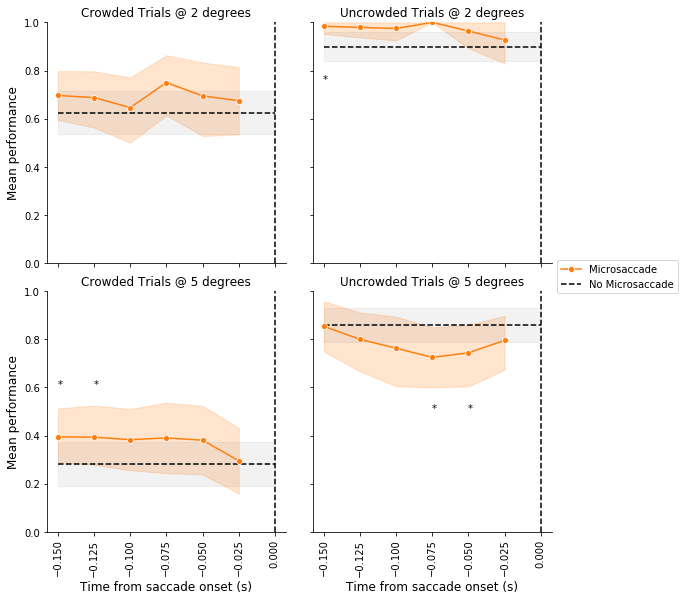

In [29]:
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='ecc',
               data=binSacc_grouped)
g.map(sns.lineplot,'binPt','corr',ci=95,marker='o',color='C1',label='Microsaccade')
g.axes[0,0].set_ylabel('Mean performance',size=12)
g.axes[1,0].set_ylabel('Mean performance',size=12)
g.axes[1,0].set_xlabel('Time from saccade onset (s)',size=12)
g.axes[0,0].set_ylim([0,1])
g.axes[0,1].set_ylim([0,1])
g.axes[1,1].set_xlabel('Time from saccade onset (s)',size=12)
spacingList=[1.6,100,1.6,100]
eccList=[2,2,5,5]
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    eccVal=eccList[axCounter]
    yVal=behavDataNoSaccade.query("spacing==@spacingVal & ecc==@eccVal")['corr']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=np.abs(yVal.mean()-ci[0])
    ax.hlines(xmin=startPt,xmax=endPt,y=yVal.mean(),linestyle='--',label='No Microsaccade')
    x=linspace(startPt,endPt,10)
    y=np.repeat(yVal.mean(),len(x))
    ax.fill_between(x, (y-diff),(y+diff), color='grey',alpha=.1)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=0,ymax=1,x=0,color='k',linestyle='--')
    # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_fix_constant_df.query("spacing==@spacingVal & ecc==@eccVal")
    p_vals_perf=temp_df['p_val'].values
    bins=temp_df['bins'].values
    spacing_vals=temp_df['spacing'].unique()
    alpha_lvl=0.05
    for idx in range(len(temp_df)):
        a_pval=p_vals_perf[idx]
        abin=bins[idx]
        if a_pval<alpha_lvl:
            if spacing_vals==1.6:
                ax.text(abin-0.0005,0.6,'*',color='k')
            elif spacing_vals==100 and eccVal==2:
                ax.text(abin-0.0005,0.75,'*',color='k')
            elif spacing_vals==100 and eccVal==5:
                ax.text(abin-0.0005,0.5,'*',color='k')
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Crowded Trials @ 2 degrees', 'Uncrowded Trials @ 2 degrees','Crowded Trials @ 5 degrees', 'Uncrowded Trials @ 5 degrees']):
    ax.set_title(title)
# Rotate x ticks
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
plt.legend(bbox_to_anchor=(1.55,1.15))
plt.savefig('..\plots\PerfVtimefromOnset_byCrowdingCond_constantBin.svg',format='svg',dpi=1200,bbox_inches='tight')

# Prop correct plots
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='ecc',
               data=binSacc)
g.map(sns.lineplot,'binPt','propCorr',ci='sd',marker='o')
g.axes[0,0].set_ylabel('Mean performance',size=12)
g.axes[1,0].set_ylabel('Mean performance',size=12)
g.axes[1,0].set_xlabel('Time from saccade onset (s)',size=12)
g.axes[0,0].set_ylim([0,1])
g.axes[0,1].set_ylim([0,1])
g.axes[1,1].set_xlabel('Time from saccade onset (s)',size=12)
spacingList=[1.6,100,1.6,100]
eccList=[2,2,5,5]
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    eccVal=eccList[axCounter]
    yVal=binFix.query("spacing==@spacingVal & ecc==@eccVal")['propCorr']
    # We compute CI
    ci=yVal.std()#sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=np.abs(yVal.mean()-ci)
    ax.hlines(xmin=startPt,xmax=endPt,y=yVal.mean(),linestyle='--')
    x=linspace(startPt,endPt,10)
    y=np.repeat(yVal.mean(),len(x))
    ax.fill_between(x, (y-ci),(y+ci), color='b', alpha=.1)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=-1,ymax=5,x=0,color='k',linestyle='--')

    # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_fix_constant_df.query("spacing==@spacingVal & ecc==@eccVal")
    p_vals_perf=temp_df['p_val_prop'].values
    bins=temp_df['bins'].values
    spacing_vals=temp_df['spacing'].unique()
    alpha_lvl=0.05
    for idx in range(len(temp_df)):
        a_pval=p_vals_perf[idx]
        abin=bins[idx]
        if a_pval<alpha_lvl:
            if spacing_vals==1.6:
                ax.text(abin-0.0005,0.4,'*',color='k')
            else:
                ax.text(abin-0.0005,0.6,'*',color='k')
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Crowded Trials @ 2 degrees', 'Uncrowded Trials @ 2 degrees','Crowded Trials @ 5 degrees', 'Uncrowded Trials @ 5 degrees']):
    ax.set_title(title)
# Rotate x ticks
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
g.add_legend()
# plt.savefig('..\plots\PerfVtimefromOnset_byCrowdingCond_constantBin.svg',format='svg',dpi=1200,bbox_inches='tight')

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


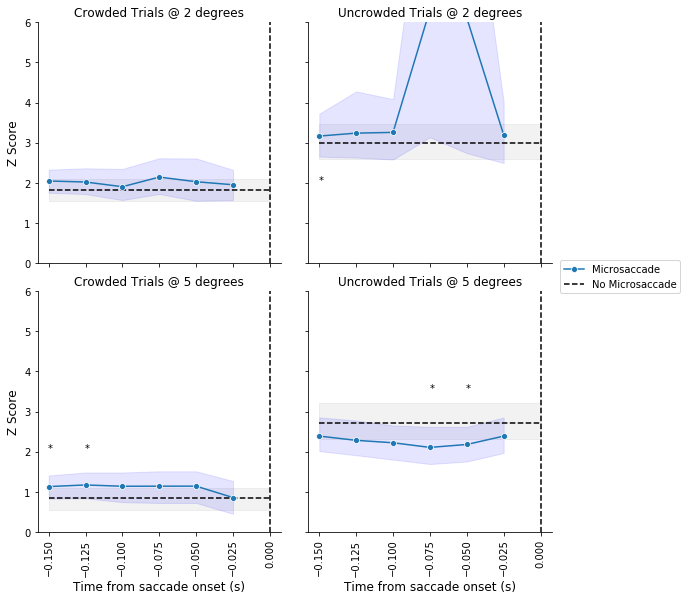

In [30]:
# z score plots
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='ecc',
               data=binSacc)
g.map(sns.lineplot,'binPt','zScores',ci=None,marker='o',color='C0',label='Microsaccade')
g.axes[0,0].set_ylabel('Z Score',size=12)
g.axes[1,0].set_ylabel('Z Score',size=12)
g.axes[1,0].set_xlabel('Time from saccade onset (s)',size=12)
g.axes[1,1].set_xlabel('Time from saccade onset (s)',size=12)
g.axes[0,0].set_ylim([0,6])
g.axes[0,1].set_ylim([0,6])
spacingList=[1.6,100,1.6,100]
eccList=[2,2,5,5]
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    eccVal=eccList[axCounter]
     # 1. Mean & 95 % CI for no saccade condition
    yVal=binFix.query("spacing==@spacingVal & ecc==@eccVal")['zScores']
    sortedyVal=np.sort(yVal)
    # We compute CI
    ax.hlines(xmin=startPt,xmax=endPt,y=yVal.mean(),linestyle='--',label='No Microsaccade')
    x=linspace(startPt,endPt,10)
    yLower=np.repeat(sortedyVal[25],len(x))
    yUpper=np.repeat(sortedyVal[975],len(x))
    ax.fill_between(x, yLower,yUpper, color='grey', alpha=.1)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=-2,ymax=12,x=0,color='k',linestyle='--')
    # 2. 95% CI for microsaccade condition
    x=[]
    yLower=[]
    yUpper=[]
    for abin in binSacc.binPt.unique():
        ySacc=binSacc.query("spacing==@spacingVal & ecc==@eccVal & binPt==@abin")['zScores']
        sortedYSacc=np.sort(ySacc)
        # We compute CI
        x.append(abin)
        yLower.append(sortedYSacc[25])
        yUpper.append(sortedYSacc[975])
    ax.fill_between(x, yLower,yUpper, color='b', alpha=.1)
#     # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_fix_zScore_constant_df.query("spacing==@spacingVal & ecc==@eccVal")
    p_vals_perf=temp_df['p_val'].values
    bins=temp_df['bins'].values
    spacing_vals=temp_df['spacing'].unique()
    alpha_lvl=0.05
    for idx in range(len(temp_df)):
        a_pval=p_vals_perf[idx]
        abin=bins[idx]
        if a_pval<alpha_lvl:
            if spacing_vals==1.6:
                ax.text(abin-0.0005,2,'*',color='k')
            elif spacing_vals==100:
                if eccVal==2:
                    ax.text(abin-0.0005,2,'*',color='k')
                else:
                    ax.text(abin-0.0005,3.5,'*',color='k')
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Crowded Trials @ 2 degrees', 'Uncrowded Trials @ 2 degrees','Crowded Trials @ 5 degrees', 'Uncrowded Trials @ 5 degrees']):
    ax.set_title(title)
# Rotate x ticks
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
plt.legend(bbox_to_anchor=(1.55,1.15))
plt.savefig('..\plots\ZScoreVTimefromSaccadeOnsetbyCrowdingCond_constantBin.svg',format='svg',dpi=1200,bbox_inches='tight')

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


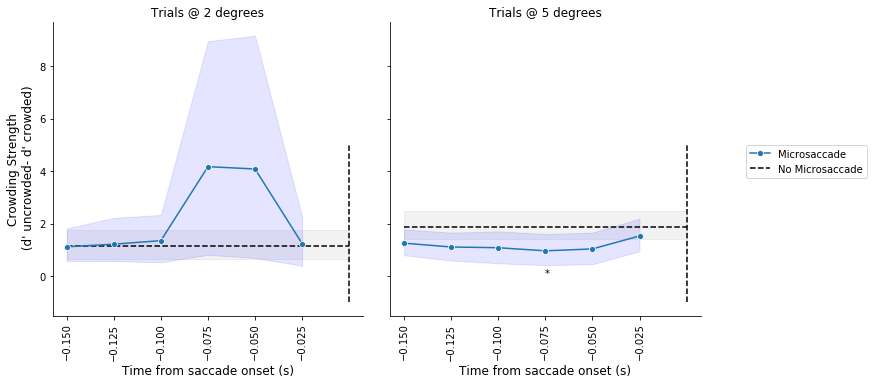

In [39]:
# z score plots
g=sns.FacetGrid(size=5, aspect=1,col='ecc',
               data=crowding_strengthSacc_df)
g.map(sns.lineplot,'binPt','crowding_strength',ci=None,marker='o',label='Microsaccade')

g.axes[0,0].set_ylabel("Crowding Strength\n (d' uncrowded- d' crowded)",size=12)
# g.axes[1,0].set_ylabel("Crowding Strength\n (d' uncrowded- d' crowded)",size=12)
g.axes[0,0].set_xlabel('Time from saccade onset (s)',size=12)
g.axes[0,1].set_xlabel('Time from saccade onset (s)',size=12)


eccList=[2,5]
axCounter=0
axes = g.fig.axes
for ax in axes:
    eccVal=eccList[axCounter]
    # 1. Mean & 95 % CI for no saccade condition
    yVal=crowding_strengthFix_df.query("ecc==@eccVal")['crowding_strength']
    sortedyVal=np.sort(yVal)
    # We compute CI
    ax.hlines(xmin=startPt,xmax=endPt,y=yVal.mean(),linestyle='--',label='No Microsaccade')
    x=linspace(startPt,endPt,10)
    yLower=np.repeat(sortedyVal[25],len(x))
    yUpper=np.repeat(sortedyVal[975],len(x))
    ax.fill_between(x, yLower,yUpper, color='grey', alpha=.1)

    # 2. 95% CI for microsaccade condition
    x=[]
    yLower=[]
    yUpper=[]
    for abin in binSacc.binPt.unique():
        ySacc=crowding_strengthSacc_df.query("ecc==@eccVal & binPt==@abin")['crowding_strength']
        sortedYSacc=np.sort(ySacc)
        # We compute CI
        x.append(abin)
        yLower.append(sortedYSacc[25])
        yUpper.append(sortedYSacc[975])
    ax.fill_between(x, yLower,yUpper, color='b', alpha=.1)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=-1,ymax=5,x=0,color='k',linestyle='--')
    #     # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_crowding_strength_df.query("ecc==@eccVal")
    p_vals_perf=temp_df['p_val'].values
    bins=temp_df['bins'].values
    alpha_lvl=0.05
    for idx in range(len(temp_df)):
        a_pval=p_vals_perf[idx]
        abin=bins[idx]
        if a_pval<alpha_lvl:
            ax.text(abin-0.0005,0,'*',color='k')
    
    axCounter+=1
plt.xticks(np.arange(-0.150,0,0.025))
# Change column headers
for ax, title in zip(g.axes.flat, ['Trials @ 2 degrees','Trials @ 5 degrees']):
    ax.set_title(title)
# Rotate x ticks
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
plt.legend(bbox_to_anchor=(1.55,0.6))
plt.savefig('..\plots\crowdingStrength_ecc.svg',format='svg',dpi=1200,bbox_inches='tight')

In [250]:
from statsmodels.stats.anova import AnovaRM
for anecc in eccs:
    for aspacing in spacings:
        data=binSacc_subj.query("spacing==@aspacing & ecc==@anecc")
        # we run anova for each condition
        print("Eccentricity: %d & Spacing: %2f"%(anecc,aspacing))
        aovrm=AnovaRM(data,'zScore','subj',within=['binPt'],aggregate_func='mean')
        res=aovrm.fit()
        print(res)

Eccentricity: 2 & Spacing: 1.600000
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
binPt  2.4874 5.0000 15.0000 0.0785

Eccentricity: 2 & Spacing: 100.000000
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
binPt  1.0000 5.0000 15.0000 0.4509

Eccentricity: 5 & Spacing: 1.600000
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
binPt  1.7169 5.0000 15.0000 0.1914

Eccentricity: 5 & Spacing: 100.000000
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
binPt  0.6906 5.0000 15.0000 0.6382



In [198]:
import warnings
warnings.filterwarnings("ignore")
for anecc in eccs:
    for aspacing in spacings:
        print("Eccentricity: %d & Spacing: %2f"%(anecc,aspacing))

        df1=binSacc_subj.query("spacing==@aspacing & ecc==@anecc")
        df1['microsaccade_cond']='microsaccade'
        df2=binFix_subj.query("spacing==@aspacing & ecc==@anecc")
        df2['microsaccade_cond']='no_microsaccade'
        mergedDF=df1.append(df2)

        aovrm=AnovaRM(mergedDF,'propCorr','subj',within=['microsaccade_cond'],aggregate_func='mean')
        res=aovrm.fit()
        print(res)

Eccentricity: 2 & Spacing: 1.600000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.0184 1.0000 3.0000 0.9006

Eccentricity: 2 & Spacing: 100.000000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  1.3577 1.0000 3.0000 0.3282

Eccentricity: 5 & Spacing: 1.600000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  1.0341 1.0000 3.0000 0.3841

Eccentricity: 5 & Spacing: 100.000000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  1.6856 1.0000 3.0000 0.2850



In [251]:
import warnings
warnings.filterwarnings("ignore")
for anecc in eccs:
    for aspacing in spacings:
        print("Eccentricity: %d & Spacing: %2f"%(anecc,aspacing))

        df1=binSacc_subj.query("spacing==@aspacing & ecc==@anecc")
        df1['microsaccade_cond']='microsaccade'
        df2=binFix_subj.query("spacing==@aspacing & ecc==@anecc")
        df2['microsaccade_cond']='no_microsaccade'
        mergedDF=df1.append(df2)

        aovrm=AnovaRM(mergedDF,'zScore','subj',within=['microsaccade_cond'],aggregate_func='mean')
        res=aovrm.fit()
        print(res)

Eccentricity: 2 & Spacing: 1.600000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.7832 1.0000 3.0000 0.4414

Eccentricity: 2 & Spacing: 100.000000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  2.5599 1.0000 3.0000 0.2079

Eccentricity: 5 & Spacing: 1.600000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.6806 1.0000 3.0000 0.4699

Eccentricity: 5 & Spacing: 100.000000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  1.3347 1.0000 3.0000 0.3316



In [197]:
import warnings
warnings.filterwarnings("ignore")
for anecc in eccs:
    for aspacing in spacings:
        for abin in bins:
            print("Eccentricity: %d & Spacing: %2f & bin point: %2f"%(anecc,aspacing,abin))

            df1=binSacc_subj.query("spacing==@aspacing & ecc==@anecc & binPt==@abin")
            df1['microsaccade_cond']='microsaccade'
            df2=binFix_subj.query("spacing==@aspacing & ecc==@anecc")
            df2['microsaccade_cond']='no_microsaccade'
            mergedDF=df1.append(df2)

            aovrm=AnovaRM(mergedDF,'propCorr','subj',within=['microsaccade_cond'],aggregate_func='mean')
            res=aovrm.fit()
            print(res)

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.150000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.0491 1.0000 3.0000 0.8388

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.125000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.0898 1.0000 3.0000 0.7840

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.100000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.7065 1.0000 3.0000 0.4623

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.075000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.4646 1.0000 3.0000 0.5444

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.050000
                    Anova
       

In [252]:
import warnings
warnings.filterwarnings("ignore")
for anecc in eccs:
    for aspacing in spacings:
        for abin in bins:
            print("Eccentricity: %d & Spacing: %2f & bin point: %2f"%(anecc,aspacing,abin))

            df1=binSacc_subj.query("spacing==@aspacing & ecc==@anecc & binPt==@abin")
            df1['microsaccade_cond']='microsaccade'
            df2=binFix_subj.query("spacing==@aspacing & ecc==@anecc")
            df2['microsaccade_cond']='no_microsaccade'
            mergedDF=df1.append(df2)

            aovrm=AnovaRM(mergedDF,'zScore','subj',within=['microsaccade_cond'],aggregate_func='mean')
            res=aovrm.fit()
            print(res)

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.150000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.1909 1.0000 3.0000 0.6917

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.125000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.0034 1.0000 3.0000 0.9571

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.100000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  0.1566 1.0000 3.0000 0.7187

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.075000
                    Anova
                  F Value Num DF Den DF Pr > F
----------------------------------------------
microsaccade_cond  1.6874 1.0000 3.0000 0.2848

Eccentricity: 2 & Spacing: 1.600000 & bin point: -0.050000
                    Anova
       

In [494]:
# First we create a zScore DF where we get the mean from each condition and convert to zscore
bins=binSacc_grouped.binPt.unique()
subs=binSacc_grouped.subj_id_x.unique()
# create empty lists
ecc_list_fix=[]
spacing_list_fix=[]
subj_list_fix=[]
z_score_list_fix=[]
ecc_list_sacc=[]
spacing_list_sacc=[]
z_score_list_sacc=[]
subj_list_sacc=[]
z_score_list_sacc=[]
binPt_list_sacc=[]
for anecc in eccs:
    for aspacing in spacings:
#         for asub in subs:
        fixData=behavDataNoSaccade.query("spacing==@aspacing & ecc==@anecc")['corr']
        #convert to z Score
        zScore_fix=ptozM(np.mean(fixData))
        #append to resp lists
        ecc_list_fix.append(anecc)
        spacing_list_fix.append(aspacing)
        subj_list_fix.append(asub)
        z_score_list_fix.append(zScore_fix)
        for abin in bins:
            saccdata=binSacc_grouped.query("spacing==@aspacing & ecc==@anecc & binPt==@abin")['corr']
            # We convert mean to z score
            zScore_sacc=ptozM(np.mean(saccdata))
            # append to respective lists
            ecc_list_sacc.append(anecc)
            spacing_list_sacc.append(aspacing)
            binPt_list_sacc.append(abin)
#             subj_list_sacc.append(asub)
            z_score_list_sacc.append(zScore_sacc)
zScoreDfSacc_constant=pd.DataFrame(np.column_stack((ecc_list_sacc,spacing_list_sacc,binPt_list_sacc,z_score_list_sacc)),columns=['ecc','spacing','binPt','zScore'])
# convert column data types
zScoreDfSacc_constant['ecc']=zScoreDfSacc_constant['ecc'].astype(int)
zScoreDfSacc_constant['spacing']=zScoreDfSacc_constant['spacing'].astype(float)
zScoreDfSacc_constant['binPt']=zScoreDfSacc_constant['binPt'].astype(float)
# zScoreDfSacc_constant['subj']=zScoreDfSacc_constant['subj'].astype(str)
zScoreDfSacc_constant['zScore']=zScoreDfSacc_constant['zScore'].astype(float)
# Fixation z score DF
zScoreDfFix_constant=pd.DataFrame(np.column_stack((ecc_list_fix,spacing_list_fix,z_score_list_fix)),columns=['ecc','spacing','zScore'])
# convert column data types
zScoreDfFix_constant['ecc']=zScoreDfFix_constant['ecc'].astype(int)
zScoreDfFix_constant['spacing']=zScoreDfFix_constant['spacing'].astype(float)
# zScoreDfFix_constant['subj']=zScoreDfFix_constant['subj'].astype(str)
zScoreDfFix_constant['zScore']=zScoreDfFix_constant['zScore'].astype(float)

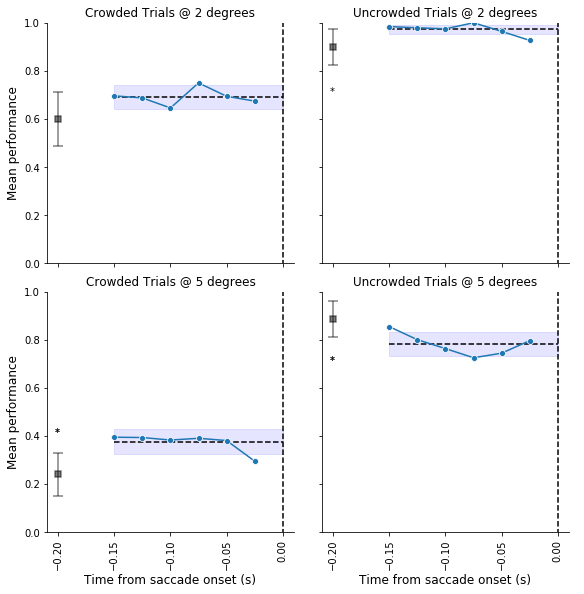

In [269]:
# Prop correct plots
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='ecc',
               data=binSacc)
g.map(sns.lineplot,'binPt','corr',ci=None,marker='o')
g.axes[0,0].set_ylabel('Mean performance',size=12)
g.axes[1,0].set_ylabel('Mean performance',size=12)
g.axes[1,0].set_xlabel('Time from saccade onset (s)',size=12)
g.axes[0,0].set_ylim([0,1])
g.axes[0,1].set_ylim([0,1])
g.axes[1,1].set_xlabel('Time from saccade onset (s)',size=12)
spacingList=[1.6,100,1.6,100]
eccList=[2,2,5,5]
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    eccVal=eccList[axCounter]
    yVal=behavDataNoSaccade.query("spacing==@spacingVal & ecc==@eccVal & subj_id!='S02'")['corr']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=np.abs(yVal.mean()-ci[0])
    min=ax.get_xlim()[0]
    max=ax.get_xlim()[1]
    ax.errorbar(-0.2,yVal.mean(),marker='s',color='k',yerr=diff,capsize=5, elinewidth=1.5, markeredgewidth=1.5,alpha=0.5)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=-1,ymax=5,x=0,color='k',linestyle='--')
    # Also add bands for mean & SD for saccade data
    saccDataPooled=binSacc.query("spacing==@spacingVal & ecc==@eccVal")['corr']
    ci=sns.utils.ci(sns.algorithms.bootstrap(saccDataPooled))
    diff=np.abs(saccDataPooled.mean()-ci[0])
    ax.hlines(xmin=startPt,xmax=endPt,y=saccDataPooled.mean(),linestyle='--')
    x=linspace(startPt,endPt,10)
    y=np.repeat(saccDataPooled.mean(),len(x))
    ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
    # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_fix_constant_df.query("spacing==@spacingVal & ecc==@eccVal")
    p_vals_perf=temp_df['p_val_prop'].values
    bins=temp_df['bins'].values
    spacing_vals=temp_df['spacing'].unique()
    alpha_lvl=0.05
    for idx in range(len(temp_df)):
        a_pval=p_vals_perf[idx]
        abin=bins[idx]
        if a_pval<alpha_lvl:
            if spacing_vals==1.6:
                ax.text(-0.203,0.4,'*',color='k')
            else:
                ax.text(-0.203,0.7,'*',color='k')
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Crowded Trials @ 2 degrees', 'Uncrowded Trials @ 2 degrees','Crowded Trials @ 5 degrees', 'Uncrowded Trials @ 5 degrees']):
    ax.set_title(title)
# Rotate x ticks
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
g.add_legend()
# plt.savefig('..\plots\PerfVtimefromOnset_byCrowdingCond_constantBin.svg',format='svg',dpi=1200,bbox_inches='tight')

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


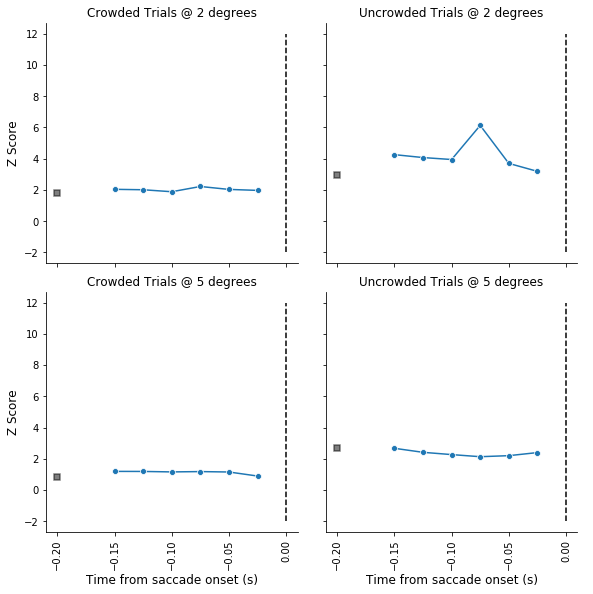

In [72]:
# z score plots
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='ecc',
               data=zScoreDfSacc_constant)
g.map(sns.lineplot,'binPt','zScore',ci=95,marker='o')
g.axes[0,0].set_ylabel('Z Score',size=12)
g.axes[1,0].set_ylabel('Z Score',size=12)
g.axes[1,0].set_xlabel('Time from saccade onset (s)',size=12)
# g.axes[0,0].set_ylim([0,1])
# g.axes[0,1].set_ylim([0,1])
g.axes[1,1].set_xlabel('Time from saccade onset (s)',size=12)
spacingList=[1.6,100,1.6,100]
eccList=[2,2,5,5]
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    eccVal=eccList[axCounter]
    yVal=zScoreDfFix_constant.query("spacing==@spacingVal & ecc==@eccVal")['zScore']
    # We compute CI
    ci=yVal.std()#sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=np.abs(yVal.mean()-ci)
    min=ax.get_xlim()[0]
    max=ax.get_xlim()[1]
    ax.errorbar(-0.2,yVal.mean(),marker='s',color='k',yerr=diff,capsize=5, elinewidth=1.5, markeredgewidth=1.5,alpha=0.5)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=-2,ymax=12,x=0,color='k',linestyle='--')
#     # Also add bands for mean & SD for saccade data
#     saccDataPooled=zScoreDfSacc_constant.query("spacing==@spacingVal & ecc==@eccVal")['zScore']
#     ci=sns.utils.ci(sns.algorithms.bootstrap(saccDataPooled))
#     diff=np.abs(saccDataPooled.mean()-ci[0])
#     ax.hlines(xmin=startPt,xmax=endPt,y=saccDataPooled.mean(),linestyle='--')
#     x=linspace(startPt,endPt,10)
#     y=np.repeat(saccDataPooled.mean(),len(x))
#     ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
#     # We add shaded regions to where we think the data are different from each other
#     temp_df=p_val_fix_constant_df.query("spacing==@spacingVal & ecc==@eccVal")
#     p_vals_perf=temp_df['p_vals_z'].values
#     bins=temp_df['bins'].values
#     spacing_vals=temp_df['spacing'].unique()
#     alpha_lvl=0.05
#     for idx in range(len(temp_df)):
#         a_pval=p_vals_perf[idx]
#         abin=bins[idx]
#         if a_pval<alpha_lvl:
#             if spacing_vals==1.6:
#                 ax.text(-0.203,1,'*',color='k')
#             else:
#                 ax.text(-0.203,6,'*',color='k')
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Crowded Trials @ 2 degrees', 'Uncrowded Trials @ 2 degrees','Crowded Trials @ 5 degrees', 'Uncrowded Trials @ 5 degrees']):
    ax.set_title(title)
# Rotate x ticks
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
g.add_legend()
# plt.savefig('..\plots\PerfVtimefromOnset_byCrowdingCond_constantBin.svg',format='svg',dpi=1200,bbox_inches='tight')

In [432]:
# 1. Stat Test between fixation condition and saccade condition
# We run permutation ftest between fixation and each of the saccade bin points individually
# We run permutation test for each time point/bin step 
bins=zScoreDfSacc_constant.binPt.unique()
bin_list=[]
ecc_list=[]
crowded_list=[]
p_vals_prop=[]
idx=1
tot_count=(len(bins)*len(zScoreDfSacc_constant.ecc.unique())*len(zScoreDfSacc_constant.spacing.unique()))
# loop through each bin
for anecc in zScoreDfSacc_constant.ecc.unique():
    for crowding_cond in zScoreDfSacc_constant.spacing.unique():
        group1=zScoreDfFix_constant.query("spacing==@crowding_cond and ecc==@anecc")['zScore']
        for abin in bins:
            print('%d/%d'%(idx,tot_count),end='\r')
            idx+=1
            # Temporary fix for crowded spacing, which otherwise retruns empty on query
            group2=zScoreDfSacc_constant.query("binPt==@abin and spacing==@crowding_cond and ecc==@anecc")['zScore'] 
            res=perm_test(group1,group2,10000,'mean',z_score=False)
            # append values to list
            bin_list.append(abin)
            p_vals_prop.append(res['p_val'])
            ecc_list.append(anecc)
            crowded_list.append(crowding_cond)
# z_score=ptoz(np.array(p_vals_perf))
np_df=np.column_stack((bin_list,p_vals_prop,ecc_list,crowded_list))
p_val_fix_zScore_constant_df=pd.DataFrame(np_df,columns=['bins','p_val_prop','ecc','spacing'])

### 2. Unequal bin widths

In [88]:
# Equal bin width method: Using dynamic binning
# This would ensure that every bin in each condition would have the same nummber of samples
# Cons: Bin centers and widths would be different in each condition
#Parameters that need to be set
startPt=-0.150
endPt=0
numBins=3
# Get experiment parameters for the loop
spacings=leftVrightData['spacing'].unique()
nums=leftVrightData['target'].unique()
eccs=[2,5]
freqBinSacc=[]
# Main loop
for anecc in eccs:
    for aspacing in spacings: 
        # create temp DF
        df=leftVrightData.query("@startPt<relStimTime<@endPt  & spacing==@aspacing & ecc==@anecc & subj_id_x!='S02'")
        if len(df)>0:
            # we split the data into equal bins
            yVal=df['relStimTime']
            qc,bins=pd.qcut(yVal,q=numBins,precision=0,retbins=True,duplicates='drop')
            # We loop through the bin points
            for binIdx in range(len(bins)-1): # we skip the last one
                start=bins[binIdx]
                end=bins[binIdx+1]
                binCenter=(start+end)/2
                # we get the binned data
                data=df.query("@start<relStimTime<@end")
                data['binWidth']=np.abs(start-end)
                data['binCenter']=binCenter
                freqBinSacc.append(data)  

freqBinSacc=pd.concat(freqBinSacc)

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [201]:
spacings=freqBinSacc.spacing.unique()
eccs=freqBinSacc.ecc.unique()
counter=1
# We create individual lists
zScoreSaccDF_dynamic=[]
zScoreFixDF_dynamic=[]
for anecc in eccs:
    for aspacing in spacings:
        tempNosaccDF=behavDataNoSaccade.query("spacing==@aspacing & ecc==@anecc")['corr']
        # We calc z score using bootstrap for the no saccade condition
        zScores=bootstrap_corr_to_z(tempNosaccDF)
        temp_zScore_df=pd.DataFrame(zScores,columns=['zScore'])
        temp_zScore_df['ecc']=anecc
        temp_zScore_df['spacing']=aspacing
        zScoreFixDF_dynamic.append(temp_zScore_df)
        bins=freqBinSacc.query("spacing==@aspacing & ecc==@anecc")['binCenter'].unique()
        for abin in bins:
            tempSaccDF=freqBinSacc.query("spacing==@aspacing & ecc==@anecc & binCenter==@abin")['corr']
            # We calculate z score using bootstrap technique
            zScores=bootstrap_corr_to_z(tempSaccDF)
            temp_zScore_df=pd.DataFrame(zScores,columns=['zScore'])
            temp_zScore_df['ecc']=anecc
            temp_zScore_df['spacing']=aspacing
            temp_zScore_df['binCenter']=abin
            zScoreSaccDF_dynamic.append(temp_zScore_df)
            counter+=1
zScoreFixDF_dynamic=pd.concat(zScoreFixDF_dynamic)
zScoreSaccDF_dynamic=pd.concat(zScoreSaccDF_dynamic)

In [91]:
# 1. Stat Test between fixation condition and saccade condition
# We run permutation ftest between fixation and each of the saccade bin points individually
# We run permutation test for each time point/bin step 
bin_list=[]
ecc_list=[]
crowded_list=[]
p_vals_prop=[]
idx=1
tot_count=16
# loop through each bin
for anecc in binSacc.ecc.unique():
    for crowding_cond in binSacc.spacing.unique():
        tempSacc=freqBinSacc.query("ecc==@anecc & spacing==@crowding_cond")
        bins=tempSacc.binCenter.unique()
        group1_prop=behavDataNoSaccade.query("spacing==@crowding_cond and ecc==@anecc and subj_id!='S02'")['corr']
        for abin in bins:
            print('%d/%d'%(idx,tot_count),end='\r')
            idx+=1
            # Temporary fix for crowded spacing, which otherwise retruns empty on query
            group2_prop=freqBinSacc.query("binCenter==@abin and spacing==@crowding_cond and ecc==@anecc & corr<2 and subj_id_x!='S02'")['corr'] 
            res_prop=perm_test(group1_prop,group2_prop,10000,'mean',z_score=True)
            # append values to list
            bin_list.append(abin)
            p_vals_prop.append(res_prop['p_val'])
            ecc_list.append(anecc)
            crowded_list.append(crowding_cond)
# z_score=ptoz(np.array(p_vals_perf))
np_df=np.column_stack((bin_list,p_vals_prop,ecc_list,crowded_list))
p_val_fix_dynamic_df=pd.DataFrame(np_df,columns=['bins','p_val_prop','ecc','spacing'])

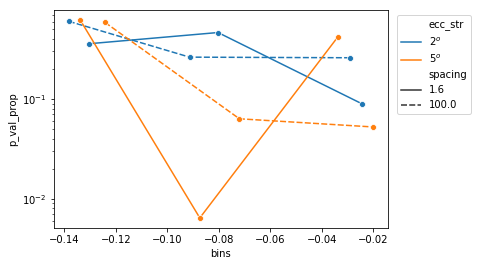

In [92]:
p_val_fix_dynamic_df['ecc_str']=np.where(p_val_fix_dynamic_df['ecc']==2,"$2^o$","$5^o$")

sns.lineplot(x='bins',y='p_val_prop',data=p_val_fix_dynamic_df,marker='o',ci=None,hue='ecc_str',style='spacing')
plt.legend(bbox_to_anchor=(1.01,1))
plt.yscale('log')


In [79]:
# We compare between the saccade bins
tot_reps=len(eccs)* len(spacings)
counter=1
p_val_sacc=[]
ecc_list=[]
spacing_list=[]
for anecc in eccs:
    for aspacing in spacings:
        print("%d/%d"%(counter,tot_reps))
        df=freqBinSacc.query("spacing==@aspacing & ecc==@anecc")
        # we segrate them based on different bin centers
        bins=df.binCenter.unique()
        group1=df.query("binCenter==@bins[0]")['corr']
        group2=df.query("binCenter==@bins[1]")['corr'][0:len(group1)]
        group3=df.query("binCenter==@bins[2]")['corr'][0:len(group1)]
        group4=df.query("binCenter==@bins[3]")['corr'][0:len(group1)]
        res=stats.friedmanchisquare(group1,group2,group3,group4)
        # append results
        p_val_sacc.append(res.pvalue)
        ecc_list.append(anecc)
        spacing_list.append(aspacing)
        counter+=1
p_val_sacc_dynamic_df=pd.DataFrame(np.column_stack((p_val_sacc,ecc_list,spacing_list)),columns=['p_val','ecc','spacing'])

1/4
2/4
3/4
4/4


C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


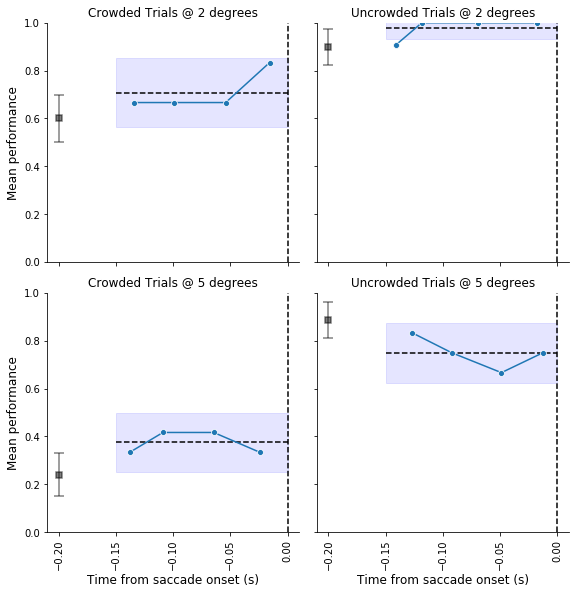

In [80]:
# Proportion Correct plots
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='ecc',
               data=freqBinSacc)
g.map(sns.lineplot,'binCenter','corr',ci=None,marker='o')
# Two options for no microsaccade condition
# 1. Horizontal line with error bars : 'horz' 
# 2. Point with error bars: 'point'
no_sacc_plot_type='point'
g.axes[0,0].set_ylabel('Mean performance',size=12)
g.axes[1,0].set_ylabel('Mean performance',size=12)
g.axes[1,0].set_xlabel('Time from saccade onset (s)',size=12)
g.axes[0,0].set_ylim([0,1])
g.axes[0,1].set_ylim([0,1])
g.axes[1,1].set_xlabel('Time from saccade onset (s)',size=12)
spacingList=[1.6,100,1.6,100]
eccList=[2,2,5,5]
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    eccVal=eccList[axCounter]
    yVal=behavDataNoSaccade.query("spacing==@spacingVal and ecc==@eccVal & subj_id!='S02'")['corr']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal,n_boot=1000))
    diff=np.abs(yVal.mean()-ci[0])
    min=ax.get_xlim()[0]
    max=ax.get_xlim()[1]
    x=linspace(min,max,10)
    y=np.repeat(yVal.mean(),len(x))
    if no_sacc_plot_type=='horz':
        ax.hlines(xmin=min,xmax=max,y=yVal.mean(),linestyle='--',color=[0,0,0])
        ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
    elif no_sacc_plot_type=='point':
        ax.errorbar(startPt-0.050,yVal.mean(),marker='s',color='k',yerr=diff,capsize=5, elinewidth=1.5, markeredgewidth=1.5,alpha=0.5)
    # Also add bands for mean & SD for saccade data
    saccDataPooled=freqBinSacc.query("spacing==@spacingVal & ecc==@eccVal")['corr']
    ci=sns.utils.ci(sns.algorithms.bootstrap(saccDataPooled))
    diff=np.abs(saccDataPooled.mean()-ci[0])
    ax.hlines(xmin=startPt,xmax=endPt,y=saccDataPooled.mean(),linestyle='--')
    x=linspace(startPt,endPt,10)
    y=np.repeat(saccDataPooled.mean(),len(x))
    ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=0,ymax=1,x=0,color='k',linestyle='--')
    # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_fix_dynamic_df.query("spacing==@spacingVal & ecc==@eccVal ")
    p_vals_perf=temp_df['p_val_prop'].values
    bins=temp_df['bins'].values
    alpha_lvl=0.05
    start_bins=[]
    end_bins=[]
    for idx in range(len(temp_df)):
        a_pval=p_vals_perf[idx]
        abin=bins[idx]
        if a_pval<alpha_lvl:
            if spacingVal==1.6:
                ax.text(startPt-0.053,0.4,'*',fontsize=12)
            elif spacingVal==100:
                ax.text(startPt-0.053,0.7,'*',fontsize=12)
    # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_sacc_dynamic_df.query("spacing==@spacingVal & ecc==@eccVal")
    p_vals_perf=temp_df['p_val'].values
    alpha_lvl=0.05
    if p_vals_perf<alpha_lvl:
        ax.text(-.075,0.7,'*',fontsize=12)
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Crowded Trials @ 2 degrees', 'Uncrowded Trials @ 2 degrees','Crowded Trials @ 5 degrees', 'Uncrowded Trials @ 5 degrees']):
    ax.set_title(title)
# Rotate x ticks
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
g.add_legend()
# plt.savefig('..\plots\PerfVtimefromOnset_byCrowdingCond_dynamicBinning.svg',format='svg',dpi=1200,bbox_inches='tight')

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


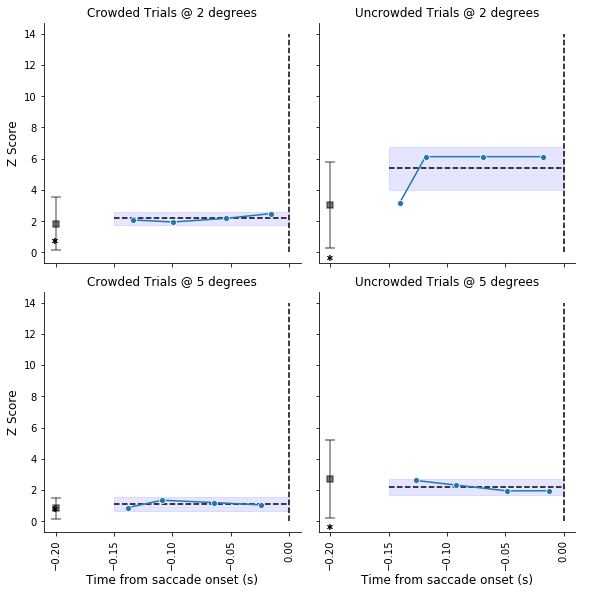

In [206]:
# zscore plots
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='ecc',
               data=zScoreSaccDF_dynamic)
g.map(sns.lineplot,'binCenter','zScore',ci=None,marker='o')
# Two options for no microsaccade condition
# 1. Horizontal line with error bars : 'horz' 
# 2. Point with error bars: 'point'
no_sacc_plot_type='point'
g.axes[0,0].set_ylabel('Z Score',size=12)
g.axes[1,0].set_ylabel('Z Score',size=12)
g.axes[1,0].set_xlabel('Time from saccade onset (s)',size=12)

g.axes[1,1].set_xlabel('Time from saccade onset (s)',size=12)
spacingList=[1.6,100,1.6,100]
eccList=[2,2,5,5]
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    eccVal=eccList[axCounter]
    yVal=zScoreFixDF_dynamic.query("spacing==@spacingVal and ecc==@eccVal")['zScore']
    # We compute CI
    ci=yVal.std() #sns.utils.ci(sns.algorithms.bootstrap(yVal,n_boot=1000))
    diff=np.abs(yVal.mean()-ci)
    min=ax.get_xlim()[0]
    max=ax.get_xlim()[1]
    x=linspace(min,max,10)
    y=np.repeat(yVal.mean(),len(x))
    if no_sacc_plot_type=='horz':
        ax.hlines(xmin=min,xmax=max,y=yVal.mean(),linestyle='--',color=[0,0,0])
        ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
    elif no_sacc_plot_type=='point':
        ax.errorbar(startPt-0.050,yVal.mean(),marker='s',color='k',yerr=diff,capsize=5, elinewidth=1.5, markeredgewidth=1.5,alpha=0.5)
    # Also add bands for mean & SD for saccade data
    saccDataPooled=zScoreSaccDF_dynamic.query("spacing==@spacingVal & ecc==@eccVal")['zScore']
    ci=saccDataPooled.std()#sns.utils.ci(sns.algorithms.bootstrap(saccDataPooled))
    ax.hlines(xmin=startPt,xmax=endPt,y=saccDataPooled.mean(),linestyle='--')
    x=linspace(startPt,endPt,10)
    y=np.repeat(saccDataPooled.mean(),len(x))
    ax.fill_between(x, (y-ci),(y+ci), color='b', alpha=.1)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=0,ymax=14,x=0,color='k',linestyle='--')
    # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_fix_dynamic_df.query("spacing==@spacingVal & ecc==@eccVal ")
    p_vals_perf=temp_df['p_vals_z'].values
    bins=temp_df['bins'].values
    alpha_lvl=0.05
    start_bins=[]
    end_bins=[]
    for idx in range(len(temp_df)):
        a_pval=p_vals_perf[idx]
        abin=bins[idx]
        if a_pval<alpha_lvl:
            if spacingVal==1.6:
                ax.text(startPt-0.053,0.4,'*',fontsize=12)
            elif spacingVal==100:
                ax.text(startPt-0.053,-0.7,'*',fontsize=12)
    # We add shaded regions to where we think the data are different from each other
    temp_df=p_val_sacc_dynamic_df.query("spacing==@spacingVal & ecc==@eccVal")
    p_vals_perf=temp_df['p_val'].values
    alpha_lvl=0.05
    if p_vals_perf<alpha_lvl:
        ax.text(-.075,0.7,'*',fontsize=12)
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Crowded Trials @ 2 degrees', 'Uncrowded Trials @ 2 degrees','Crowded Trials @ 5 degrees', 'Uncrowded Trials @ 5 degrees']):
    ax.set_title(title)
# Rotate x ticks
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
g.add_legend()
# plt.savefig('..\plots\PerfVtimefromOnset_byCrowdingCond_dynamicBinning.svg',format='svg',dpi=1200,bbox_inches='tight')

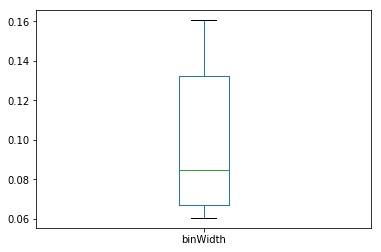

In [281]:
freqBinSacc.binWidth.plot(kind='box')

Text(0,0.5,'Number of trials')

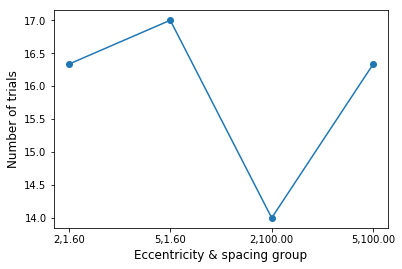

In [89]:
cond_list=[]
count_list=[]
for aspacing in spacings:
    for anecc in eccs:
        df=freqBinSacc.query("spacing==@aspacing & ecc==@anecc")
        bins=df.binCenter.unique()
        cond="%d,%.2f" %(anecc,aspacing)
        cond_list.append(cond)
        trial_count=len(df)/len(bins)
        count_list.append(trial_count)
plt.plot(cond_list,count_list,marker='o')
plt.xlabel('Eccentricity & spacing group',fontsize=12)
plt.ylabel('Number of trials',fontsize=12)

In [20]:
# Save the dataframes
# binSacc.to_csv('binnedData_constantBin_50msStep_125msWindow.csv')
# p_val_fix_constant_df.to_csv('p_val_constant_df.csv')
# freqBinSacc.to_csv('binnedData_dynamicBin.csv')
# p_val_fix_dynamic_df.to_csv('p_val_dynamic_fix_df.csv')
# p_val_sacc_dynamic_df.to_csv('p_val_dynamic_sacc_df.csv')

## Microsaccade direction plot
We mainly see rightward bias since all stimuli were presented to the right from fixation

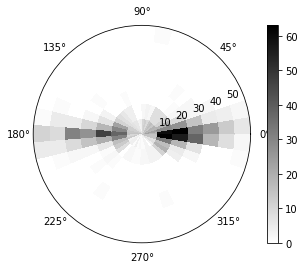

In [160]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that
# are below 0
relSaccData['DirectionPolar']=0
for i in range(len(relSaccData)):
    if relSaccData['Direction'].iloc[i]<0:
        relSaccData['DirectionPolar'].iloc[i]=relSaccData['Direction'].iloc[i]+360
    else:
        relSaccData['DirectionPolar'].iloc[i]=relSaccData['Direction'].iloc[i]

# two input arrays
data=relSaccData.query("VectorAmp<1")
azimut=np.radians(data['DirectionPolar'])
radius=data['VectorAmp']*60

# define binning
rbins = np.linspace(0,radius.max(), 8)
abins = np.linspace(0,2*np.pi, 40)

#calculate histogram
hist, _, _ = np.histogram2d(azimut, radius, bins=(abins, rbins))
A, R = np.meshgrid(abins, rbins)

# plot
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
pc = ax.pcolormesh(A, R, hist.T, cmap="binary")
ax.set_theta_zero_location("E")  # theta=0 on the left
ax.set_theta_direction(1) 
# ax.set_title('All Trials')
fig.colorbar(pc)
# plotFilename=('..\Plots\MicrosaccadeDirectionAlldeg.svg')
# plt.savefig(plotFilename,bbox_tight= True,format='svg',dpi=1200)


## Mislocalization of behavioral response
We look for trials where subjects report one of the flankers instead of the target

In [27]:
codeList=behavData.query("spacing!=100.0").code.unique()
misLoc=[]
for acode in codeList:
    tempData=behavData.query("code==@acode")
    # we get only the data from the last presentation and ignore the other ones
    lastStim=tempData.tail(1)
    behavResp=lastStim.resp.values[0]
    # we get the flankers used in that trial
    flankersUsed=[lastStim.outer.values[0],lastStim.up.values[0],lastStim.down.values[0]]
    # Eliminate trials where there was a correct response
    if lastStim.corr!=0:
        # check if the subject reported one of the flankers / mislocalization
        if behavResp in flankersUsed:
            if behavResp==lastStim.outer.values[0]:
                lastStim['misloc_pos']='outer'
            elif behavResp==lastStim.up.values[0]:
                lastStim['misloc_pos']='up'
            elif behavResp==lastStim.down.values[0]:
                lastStim['misloc_pos']='down'
            misLoc.append(lastStim)
mislocalizedTrials=pd.concat(misLoc)

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Text(0.5, 0, 'Flanker Mislocalized')

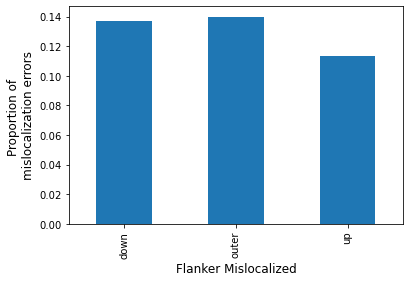

In [35]:
numErrors=len(behavData.query("corr==0"))
(mislocalizedTrials.groupby(['misloc_pos'])['corr'].count()/numErrors).plot(kind='bar')
plt.ylabel('Proportion of \nmislocalization errors',size=12)
plt.xlabel('Flanker Mislocalized',size=12)

Text(0.5, 0, 'Flanker Mislocalized')

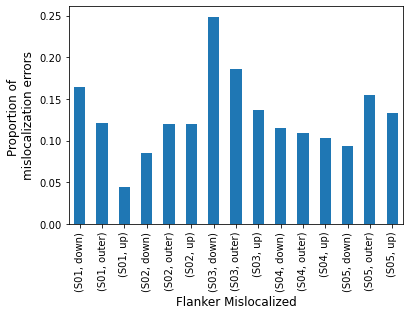

In [36]:
numErrors=behavData.query("corr==0").groupby('subj_id')['corr'].count()
(mislocalizedTrials.groupby(['subj_id','misloc_pos'])['corr'].count()/numErrors).plot(kind='bar')
plt.ylabel('Proportion of \nmislocalization errors',size=12)
plt.xlabel('Flanker Mislocalized',size=12)

<AxesSubplot:xlabel='resp'>

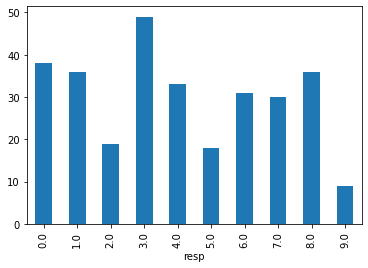

In [28]:
mislocalizedTrials.groupby('resp')['corr'].count().plot(kind='bar')

Text(0.5, 0, 'Response')

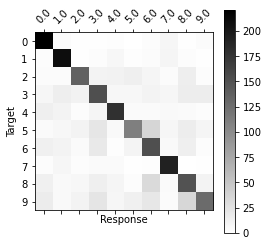

In [33]:
from sklearn.metrics import confusion_matrix
df_confusion = pd.crosstab(behavData['target'],behavData.query("resp!=100")['resp'])
plt.matshow(df_confusion, cmap=plt.cm.gray_r) # imshow
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, (df_confusion.columns), rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel('Target')
plt.xlabel('Response')

Text(0.5, 0, 'Response')

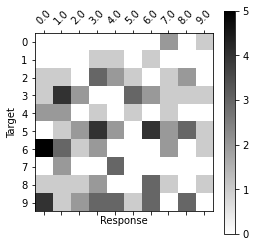

In [29]:
from sklearn.metrics import confusion_matrix
df=mislocalizedTrials.query("misloc_pos=='outer'")
df_confusion = pd.crosstab(df['target'],df['resp'])
plt.matshow(df_confusion, cmap=plt.cm.gray_r) # imshow
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel('Target')
plt.xlabel('Response')